In [1]:
"""
LSTM States Spatial Analysis
============================
Analyze how LSTM hidden states internally represent meteorological processes
(evaporation, SWE, snow depth, subsurface flow) that were NOT included as model inputs.

Key Questions:
1. Do similar regions use the same LSTM cells for the same physical processes?
2. Can we label/group cells by their associated processes?
"""
from pathlib import Path
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append("../")

from src.plots.hex_maps import hexes_plots_n
from src.readers.geom_reader import load_geodata
from src.utils.logger import setup_logger

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
log = setup_logger("chapter_three", log_file="../logs/chapter_three.log")


In [2]:
# =============================================================================
# Output directories
# =============================================================================
table_dir = Path("../res/chapter_three/tables")
table_dir.mkdir(parents=True, exist_ok=True)
image_dir = Path("../res/chapter_three/images")
image_dir.mkdir(parents=True, exist_ok=True)

# =============================================================================
# Load gauge geometries and hybrid cluster assignments
# =============================================================================
ws, gauges = load_geodata(folder_depth="../")
common_index = gauges.index.to_list()
basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")

# Hybrid clusters combine geographical (Ф1-Ф10) + hydrological (Г1-Г10) similarity
gauge_mapping = pd.read_csv(
    "../res/chapter_one/gauge_hybrid_mapping.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
hybrid_clusters = gauge_mapping["hybrid_class"]

print(f"Loaded {len(gauges)} gauges with hybrid classification")
print(f"Unique hybrid classes: {hybrid_clusters.nunique()}")
print(f"\nHybrid class distribution:\n{hybrid_clusters.value_counts()}")


Loaded 996 gauges with hybrid classification
Unique hybrid classes: 16

Hybrid class distribution:
hybrid_class
Ф4-Г8       157
Ф10-Г3      119
Ф9-Г7       110
Ф1-Г5        81
Ф8-Г2        74
Ф7-Г1        71
Ф5-Г2        63
Ф2-Mixed     54
Ф6-Г10       40
Ф10-Г1       40
Ф9-Г9        36
Ф1-Г1        36
Ф1-Г3        35
Ф3-Г4        31
Ф10-Г10      25
Ф7-Г2        24
Name: count, dtype: int64


In [3]:
# =============================================================================
# Load LSTM states from saved npz file
# =============================================================================
states_path = Path("../data/optimization/example_states.npz")
print(f"Loading LSTM states from: {states_path}")
print(f"File size: {states_path.stat().st_size / 1e9:.2f} GB")

states = np.load(states_path)
print(f"\nAvailable keys: {list(states.keys())}")

# Inspect structure of each state tensor
for key in states.keys():
    arr = states[key]
    print(f"  {key}: shape={arr.shape}, dtype={arr.dtype}")

Loading LSTM states from: ../data/optimization/example_states.npz
File size: 1.52 GB

Available keys: ['h_n', 'c_n', 'i', 'f', 'g', 'o', 'y_hat']
  h_n: shape=(731, 365, 256), dtype=float32
  c_n: shape=(731, 365, 256), dtype=float32
  i: shape=(731, 365, 256), dtype=float32
  f: shape=(731, 365, 256), dtype=float32
  g: shape=(731, 365, 256), dtype=float32
  o: shape=(731, 365, 256), dtype=float32
  y_hat: shape=(731, 365, 1), dtype=float32


In [4]:
# =============================================================================
# Define paths to unused meteorological parameters
# These are physical processes NOT included as model inputs
# =============================================================================
METEO_PARAMS = {
    "evaporation": {
        "path": Path("../data/meteo_grids_2024/gleam/E"),
        "column": "E",
        "description": "Actual evapotranspiration (GLEAM)",
    },
    "swe": {
        "path": Path(
            "../data/meteo_grids_2024/snow_and_subsurface/era5_land/snow_depth_water_equivalent"
        ),
        "column": "swe_e5l",
        "description": "Snow Water Equivalent (ERA5-Land)",
    },
    "snow_depth": {
        "path": Path("../data/meteo_grids_2024/snow_and_subsurface/era5_land/snow_depth"),
        "column": None,  # Will auto-detect
        "description": "Snow Depth (ERA5-Land)",
    },
    "subsurface": {
        "path": Path(
            "../data/meteo_grids_2024/snow_and_subsurface/era5_land/sub_surface_runoff"
        ),
        "column": None,  # Will auto-detect
        "description": "Subsurface Runoff (ERA5-Land)",
    },
}

# Verify paths exist
for param, info in METEO_PARAMS.items():
    exists = info["path"].exists()
    n_files = len(list(info["path"].glob("*.csv"))) if exists else 0
    print(f"{param}: {info['path']} | exists={exists} | files={n_files}")

evaporation: ../data/meteo_grids_2024/gleam/E | exists=True | files=2246
swe: ../data/meteo_grids_2024/snow_and_subsurface/era5_land/snow_depth_water_equivalent | exists=True | files=2241
snow_depth: ../data/meteo_grids_2024/snow_and_subsurface/era5_land/snow_depth | exists=True | files=2241
subsurface: ../data/meteo_grids_2024/snow_and_subsurface/era5_land/sub_surface_runoff | exists=True | files=2241


In [5]:
# =============================================================================
# Core correlation function
# Returns ALL correlations between LSTM cells and meteorological data
# =============================================================================
def compute_all_cell_correlations(
    cell_states: np.ndarray,  # Shape: (n_timesteps, hidden_size)
    meteo_array: np.ndarray,  # Shape: (n_timesteps,)
) -> np.ndarray:
    """
    Compute Pearson correlation between each LSTM cell and meteorological data.

    Returns array of shape (hidden_size,) with correlation coefficients.
    """
    # Align lengths
    min_len = min(len(cell_states), len(meteo_array))
    cell_states = cell_states[:min_len]
    meteo_array = meteo_array[:min_len]

    # Handle NaN values in meteo data
    valid_mask = ~np.isnan(meteo_array)
    if valid_mask.sum() < 10:  # Not enough valid data
        return np.full(cell_states.shape[1], np.nan)

    cell_states = cell_states[valid_mask]
    meteo_array = meteo_array[valid_mask]

    n_cells = cell_states.shape[1]
    correlations = np.zeros(n_cells)

    for i in range(n_cells):
        # Compute correlation, handling edge cases
        try:
            corr_matrix = np.corrcoef(cell_states[:, i], meteo_array)
            correlations[i] = corr_matrix[0, 1]
        except Exception:
            correlations[i] = np.nan

    return correlations


def load_meteo_data(gauge_id: str, param_name: str, date_range=None) -> np.ndarray:
    """Load meteorological data for a specific gauge and parameter."""
    info = METEO_PARAMS[param_name]
    file_path = info["path"] / f"{gauge_id}.csv"

    if not file_path.exists():
        return np.array([])

    try:
        df = pd.read_csv(file_path, index_col="date", parse_dates=["date"])

        # Auto-detect column if not specified
        col = info["column"]
        if col is None:
            # Use first non-date column
            col = df.columns[0]

        if col not in df.columns:
            col = df.columns[0]

        if date_range is not None:
            # Filter to date range
            df = df.loc[df.index.intersection(date_range)]

        return df[col].values
    except Exception:
        return np.array([])


print("Correlation functions defined.")

Correlation functions defined.


In [6]:
# =============================================================================
# Extract LSTM cell states for correlation analysis
# =============================================================================
# From the archive notebook, states have structure:
#   h_n: hidden states, c_n: cell states
#   Shape: (n_samples, seq_len, hidden_size)
# We use the LAST timestep of each sample: [:, -1, :]

# Determine which state type to analyze
STATE_TYPE = "h_n"  # hidden state (can also try "c_n" for cell state)

if STATE_TYPE in states.keys():
    raw_states = states[STATE_TYPE]
    print(f"Using state type: {STATE_TYPE}")
    print(f"Raw shape: {raw_states.shape}")

    # Extract last timestep: (n_samples, hidden_size)
    if len(raw_states.shape) == 3:
        cell_states_all = raw_states[:, -1, :]
    else:
        cell_states_all = raw_states

    n_samples, hidden_size = cell_states_all.shape
    print(f"Cell states shape (last timestep): {cell_states_all.shape}")
    print(f"  n_samples (days): {n_samples}")
    print(f"  hidden_size: {hidden_size}")
else:
    raise ValueError(f"State type '{STATE_TYPE}' not found in saved states")

Using state type: h_n
Raw shape: (731, 365, 256)
Cell states shape (last timestep): (731, 256)
  n_samples (days): 731
  hidden_size: 256


In [7]:
# =============================================================================
# Compute per-gauge correlation matrices for all meteo parameters
# =============================================================================
# Result structure: {param_name: DataFrame with gauges as rows, cells as columns}

correlation_matrices = {}

for param_name in METEO_PARAMS.keys():
    print(f"\nProcessing: {param_name}")

    # Initialize result dataframe
    corr_df = pd.DataFrame(
        index=common_index,
        columns=range(hidden_size),
        dtype=float,
    )

    success_count = 0
    fail_count = 0

    for gauge_id in tqdm(common_index, desc=param_name):
        # Load meteo data for this gauge
        meteo_data = load_meteo_data(gauge_id, param_name)

        if len(meteo_data) == 0:
            fail_count += 1
            continue

        # Compute correlations between all cells and this meteo parameter
        correlations = compute_all_cell_correlations(cell_states_all, meteo_data)

        if not np.all(np.isnan(correlations)):
            corr_df.loc[gauge_id] = correlations
            success_count += 1
        else:
            fail_count += 1

    # Store result
    correlation_matrices[param_name] = corr_df.dropna(how="all")
    print(f"  Success: {success_count}, Failed: {fail_count}")
    print(f"  Result shape: {correlation_matrices[param_name].shape}")


Processing: evaporation


evaporation:   0%|          | 0/996 [00:00<?, ?it/s]

  Success: 996, Failed: 0
  Result shape: (996, 256)

Processing: swe


swe:   0%|          | 0/996 [00:00<?, ?it/s]

  Success: 996, Failed: 0
  Result shape: (996, 256)

Processing: snow_depth


snow_depth:   0%|          | 0/996 [00:00<?, ?it/s]

  Success: 996, Failed: 0
  Result shape: (996, 256)

Processing: subsurface


subsurface:   0%|          | 0/996 [00:00<?, ?it/s]

  Success: 996, Failed: 0
  Result shape: (996, 256)


In [8]:
# =============================================================================
# Aggregate correlations within hybrid clusters using median
# =============================================================================
def aggregate_cluster_correlations(
    corr_matrix: pd.DataFrame,  # gauges x cells
    cluster_assignments: pd.Series,  # gauge_id -> hybrid_class
) -> pd.DataFrame:
    """Aggregate correlations within hybrid clusters using median."""
    cluster_corr = {}

    for cluster in cluster_assignments.unique():
        cluster_gauges = cluster_assignments[cluster_assignments == cluster].index
        cluster_gauges = cluster_gauges.intersection(corr_matrix.index)

        if len(cluster_gauges) > 0:
            # Median correlation for each cell across gauges in cluster
            cluster_corr[cluster] = corr_matrix.loc[cluster_gauges].median()

    return pd.DataFrame(cluster_corr).T  # (n_clusters, hidden_size)


# Aggregate for each parameter
cluster_correlations = {}

for param_name, corr_df in correlation_matrices.items():
    cluster_corr = aggregate_cluster_correlations(corr_df, hybrid_clusters)
    cluster_correlations[param_name] = cluster_corr
    print(
        f"{param_name}: {cluster_corr.shape[0]} clusters x {cluster_corr.shape[1]} cells"
    )

evaporation: 16 clusters x 256 cells
swe: 16 clusters x 256 cells
snow_depth: 16 clusters x 256 cells
subsurface: 16 clusters x 256 cells


In [9]:
# =============================================================================
# Identify dominant cells per cluster for each parameter
# =============================================================================
def find_dominant_cells(
    cluster_correlations: dict,  # {param: cluster x cells DataFrame}
    top_k: int = 5,
) -> pd.DataFrame:
    """Find top-k cells for each parameter in each cluster."""
    results = []

    for param, corr_df in cluster_correlations.items():
        for cluster in corr_df.index:
            row = corr_df.loc[cluster].dropna()
            if len(row) == 0:
                continue

            # Get top-k cells by absolute correlation
            top_cells = row.abs().nlargest(top_k)

            results.append(
                {
                    "cluster": cluster,
                    "parameter": param,
                    "top_cells": list(top_cells.index),
                    "correlations": [row[c] for c in top_cells.index],
                    "best_cell": top_cells.index[0],
                    "best_corr": row[top_cells.index[0]],
                }
            )

    return pd.DataFrame(results)


dominant_cells_df = find_dominant_cells(cluster_correlations, top_k=5)
print(f"Dominant cells table: {dominant_cells_df.shape}")
dominant_cells_df.head(10)

Dominant cells table: (64, 6)


cluster    parameter              top_cells  \
0    Ф10-Г3  evaporation   [0, 231, 59, 38, 50]   
1     Ф9-Г9  evaporation   [0, 231, 86, 38, 50]   
2     Ф9-Г7  evaporation  [0, 231, 86, 50, 115]   
3     Ф7-Г2  evaporation  [231, 0, 59, 156, 38]   
4     Ф1-Г3  evaporation  [0, 231, 38, 59, 156]   
5     Ф8-Г2  evaporation   [231, 0, 59, 50, 38]   
6    Ф6-Г10  evaporation   [231, 0, 59, 50, 38]   
7     Ф1-Г5  evaporation  [0, 231, 38, 59, 156]   
8  Ф2-Mixed  evaporation  [0, 231, 38, 59, 156]   
9    Ф10-Г1  evaporation  [231, 0, 59, 156, 50]   

                                        correlations  best_cell  best_corr  
0  [-0.8318899061437509, 0.8305779535588916, -0.7...          0  -0.831890  
1  [-0.837743166071343, 0.8290448715986645, -0.80...          0  -0.837743  
2  [-0.8055662400769429, 0.7968333825898097, -0.7...          0  -0.805566  
3  [0.8147890843975614, -0.8116409320322424, -0.7...        231   0.814789  
4  [-0.8624578022638846, 0.8535326576308678, -0.8...          0  -0.862458  
5  [0.8400742052985596, -0.831581194011821, -0.80...        231   0.840074  
6  [0.8466260708243396, -0.8432869525579043, -0.8...        231   0.846626  
7  [-0.8656577124412375, 0.8471748539977071, -0.8...          0  -0.865658  
8  [-0.8608141543940007, 0.8538979773943352, -0.8...          0  -0.860814  
9  [0.8331462255530627, -0.8245757842378257, -0.8...        231   0.833146

In [10]:
# =============================================================================
# Label LSTM cells by their associated physical processes
# =============================================================================
def label_cells_by_process(
    cluster_correlations: dict,  # {param: DataFrame of cluster x cells}
    correlation_threshold: float = 0.5,
) -> pd.DataFrame:
    """
    Assign process labels to each LSTM cell based on correlation patterns.

    Categories:
    - Specialized cells: High correlation with ONE process across many regions
    - Regional cells: High correlation with a process in specific regions only
    - Multi-process cells: Correlate with different processes in different regions
    - Inactive cells: Low correlation with all processes
    """
    n_cells = hidden_size
    cell_labels = pd.DataFrame(index=range(n_cells))

    for param, corr_df in cluster_correlations.items():
        # For each cell, count how many clusters show strong correlation with this param
        strong_corr_count = (corr_df.abs() > correlation_threshold).sum()
        cell_labels[f"{param}_regions"] = strong_corr_count.values
        cell_labels[f"{param}_max_r"] = corr_df.abs().max().values
        cell_labels[f"{param}_mean_r"] = corr_df.abs().mean().values

    # Assign primary process label based on strongest association
    max_r_cols = [c for c in cell_labels.columns if "_max_r" in c]
    cell_labels["primary_process"] = (
        cell_labels[max_r_cols].idxmax(axis=1).str.replace("_max_r", "")
    )
    cell_labels["max_correlation"] = cell_labels[max_r_cols].max(axis=1)

    # Categorize cells
    def categorize_cell(row):
        if row["max_correlation"] < 0.3:
            return "inactive"

        # Check if cell is specialized (high for one, low for others)
        max_r_values = [row[c] for c in max_r_cols]
        sorted_vals = sorted(max_r_values, reverse=True)
        if len(sorted_vals) > 1 and sorted_vals[0] > 0.5 and sorted_vals[1] < 0.3:
            return "specialized"
        elif sorted_vals[0] > 0.4 and sorted_vals[1] > 0.4:
            return "multi-process"
        else:
            return "regional"

    cell_labels["category"] = cell_labels.apply(categorize_cell, axis=1)

    return cell_labels


cell_labels_df = label_cells_by_process(cluster_correlations, correlation_threshold=0.5)

# Summary
print("Cell category distribution:")
print(cell_labels_df["category"].value_counts())
print("\nPrimary process distribution:")
print(cell_labels_df["primary_process"].value_counts())

Cell category distribution:
category
multi-process    216
regional          22
inactive          17
specialized        1
Name: count, dtype: int64

Primary process distribution:
primary_process
evaporation    124
snow_depth      63
swe             35
subsurface      34
Name: count, dtype: int64


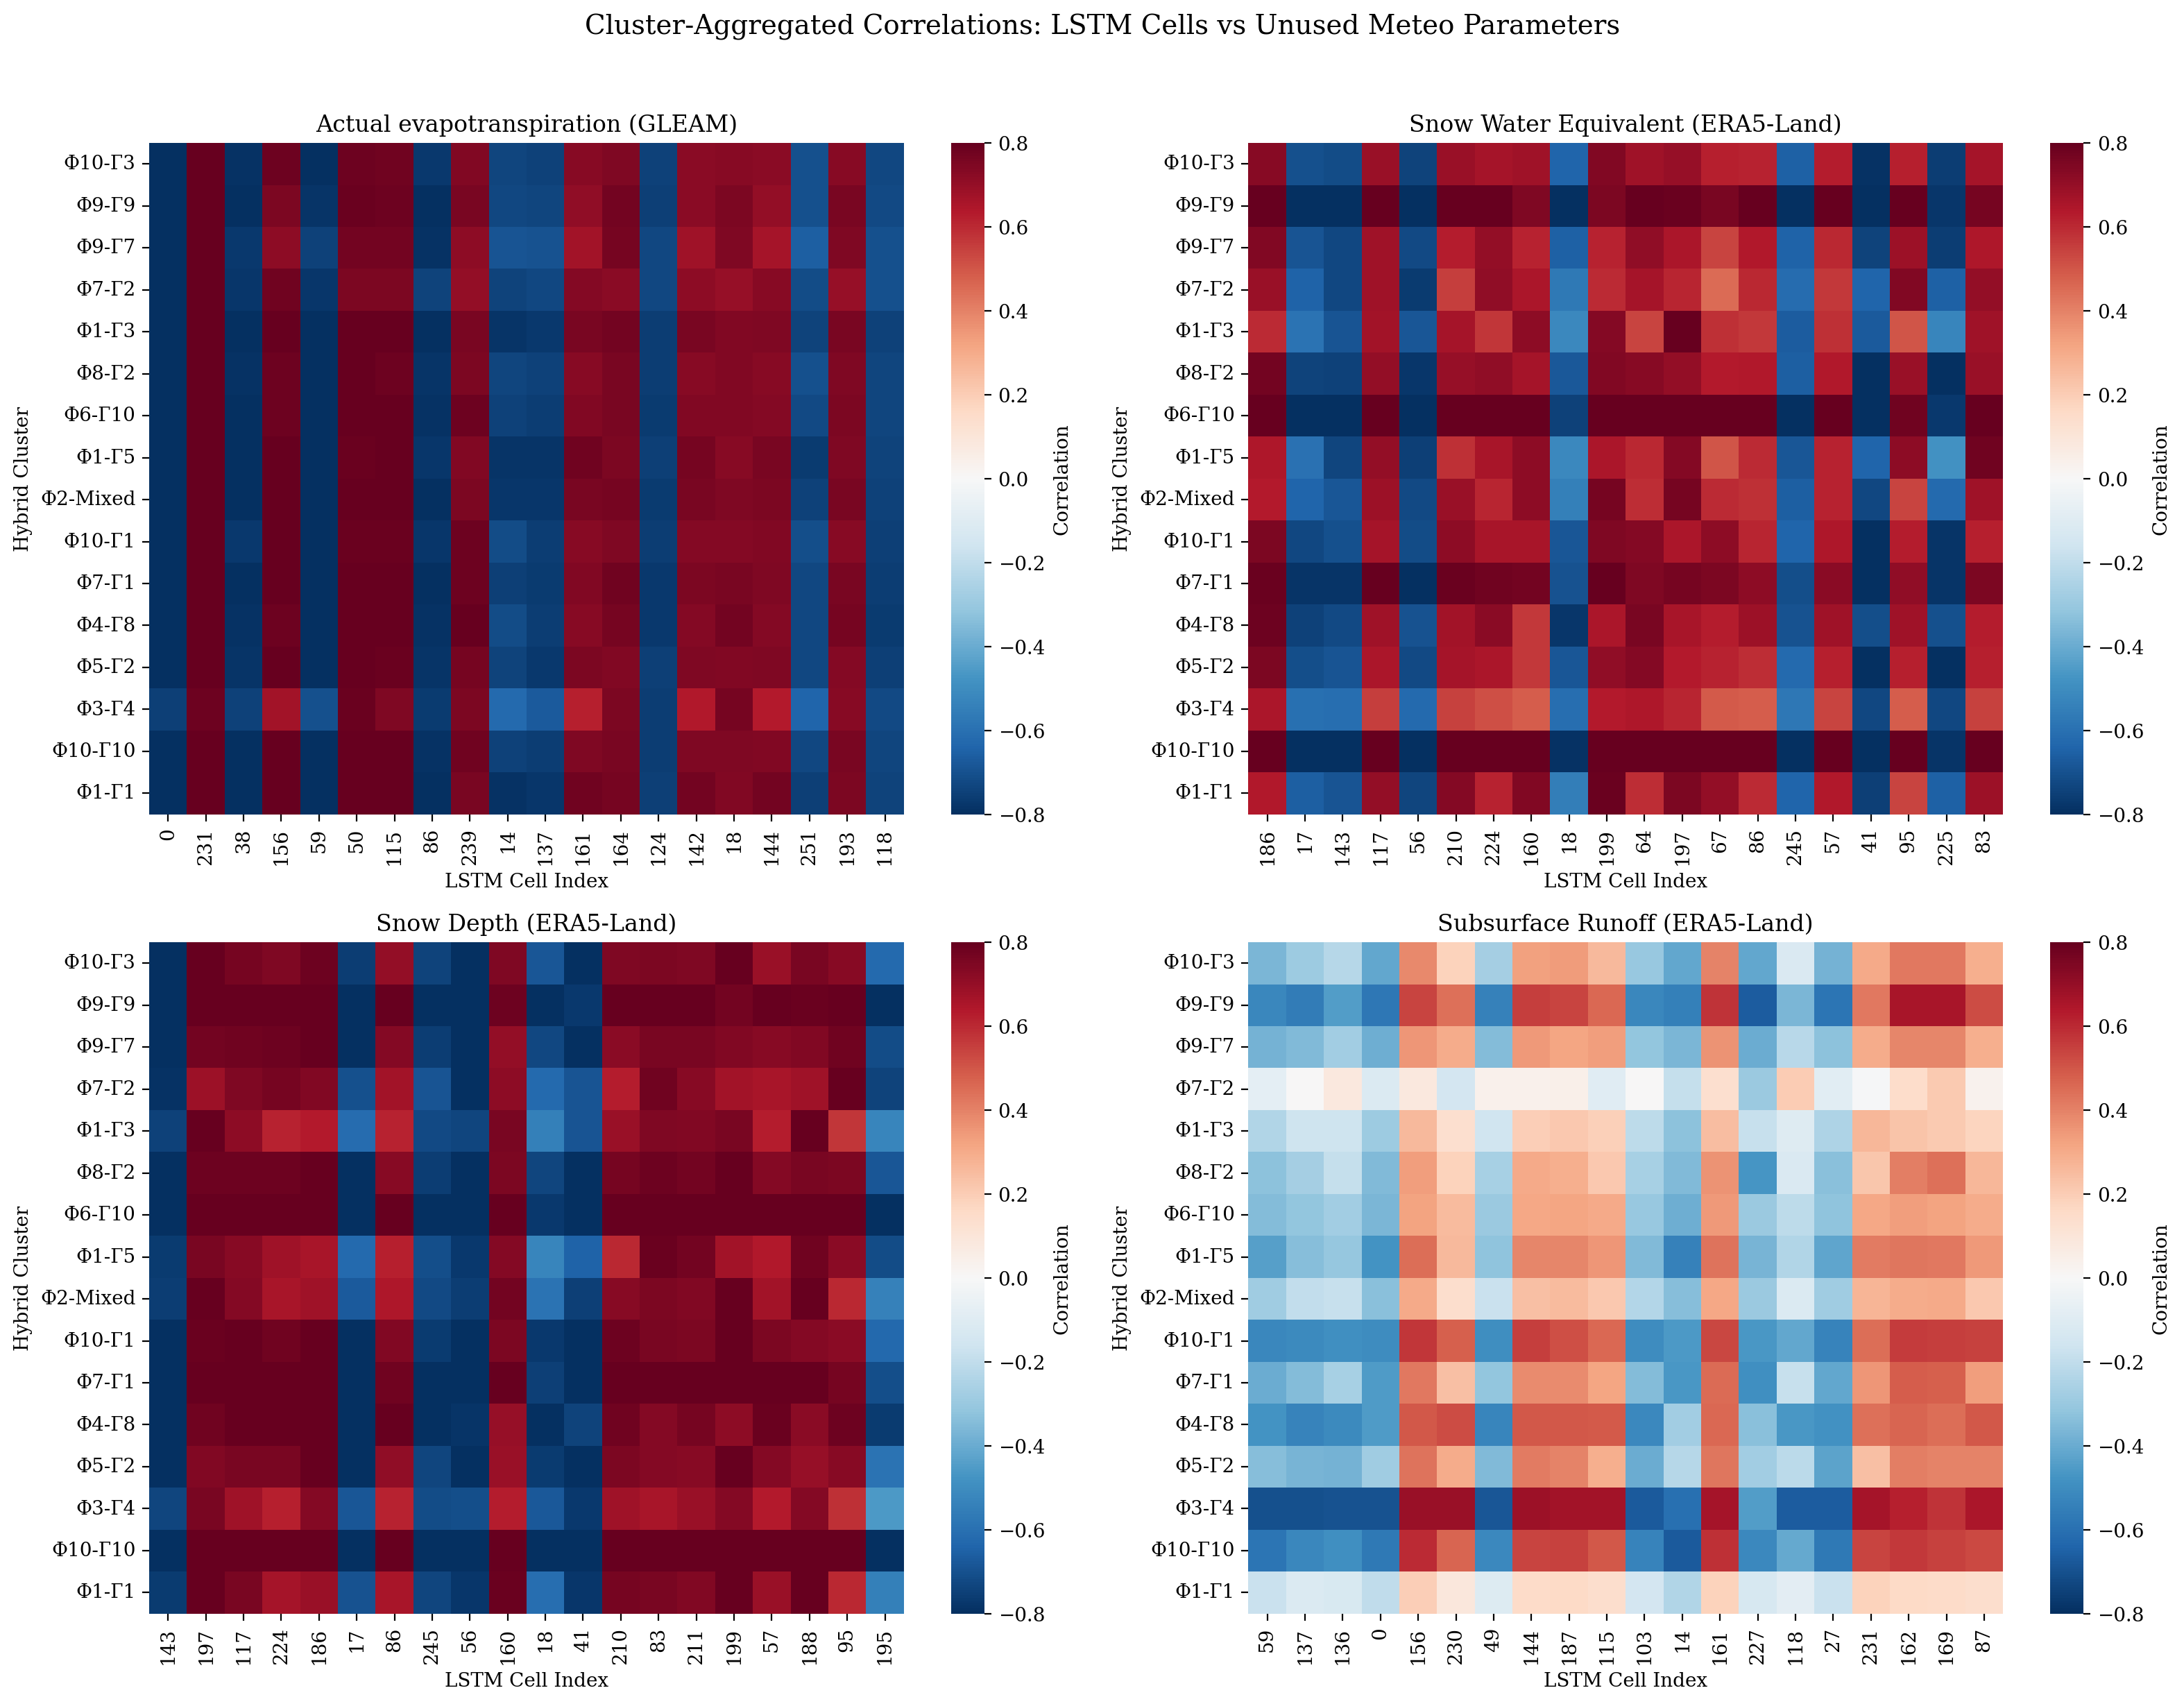

In [11]:
# =============================================================================
# Visualization: Heatmap of cluster x parameter correlation strengths
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (param, corr_df) in enumerate(cluster_correlations.items()):
    ax = axes[idx]

    # Take top 20 cells by max correlation across clusters
    top_cells = corr_df.abs().max().nlargest(20).index
    plot_data = corr_df[top_cells]

    sns.heatmap(
        plot_data,
        ax=ax,
        cmap="RdBu_r",
        center=0,
        vmin=-0.8,
        vmax=0.8,
        cbar_kws={"label": "Correlation"},
    )
    ax.set_title(f"{METEO_PARAMS[param]['description']}", fontsize=12)
    ax.set_xlabel("LSTM Cell Index")
    ax.set_ylabel("Hybrid Cluster")

plt.suptitle(
    "Cluster-Aggregated Correlations: LSTM Cells vs Unused Meteo Parameters",
    fontsize=14,
    y=1.02,
)
plt.tight_layout()
plt.savefig(
    image_dir / "lstm_cluster_correlations_heatmap.png", dpi=150, bbox_inches="tight"
)
plt.show()

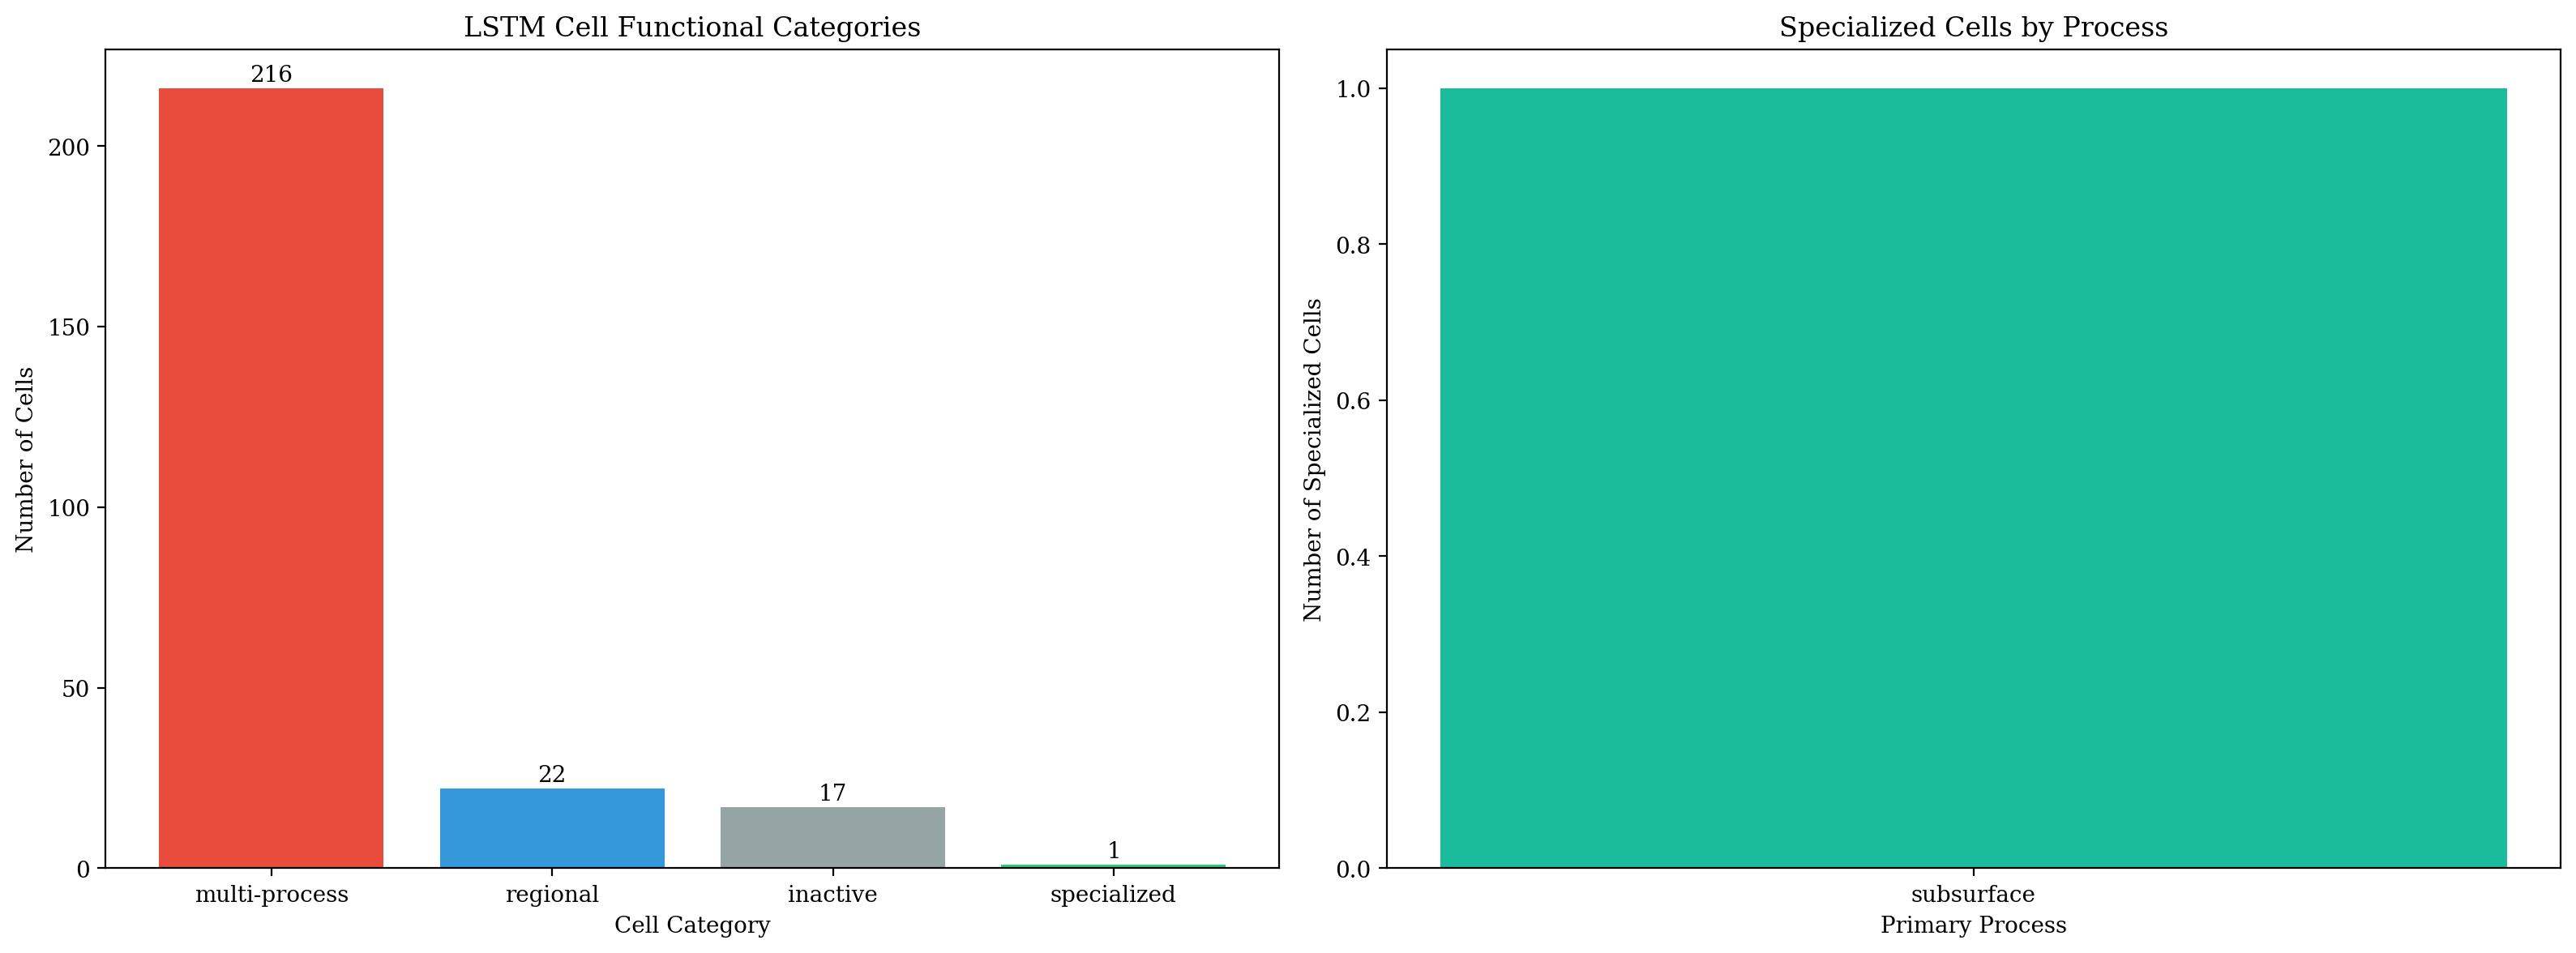

In [12]:
# =============================================================================
# Visualization: LSTM Hidden Layer Functional Map
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Cell category distribution
ax1 = axes[0]
category_counts = cell_labels_df["category"].value_counts()
colors = {
    "specialized": "#2ecc71",
    "regional": "#3498db",
    "multi-process": "#e74c3c",
    "inactive": "#95a5a6",
}
ax1.bar(
    category_counts.index,
    category_counts.values,
    color=[colors.get(c, "#333") for c in category_counts.index],
)
ax1.set_xlabel("Cell Category")
ax1.set_ylabel("Number of Cells")
ax1.set_title("LSTM Cell Functional Categories")
for i, (cat, count) in enumerate(category_counts.items()):
    ax1.text(i, count + 2, str(count), ha="center", fontsize=10)

# Right: Primary process distribution for specialized cells
ax2 = axes[1]
specialized = cell_labels_df[cell_labels_df["category"] == "specialized"]
if len(specialized) > 0:
    process_counts = specialized["primary_process"].value_counts()
    ax2.bar(
        process_counts.index,
        process_counts.values,
        color=["#1abc9c", "#3498db", "#9b59b6", "#f39c12"],
    )
    ax2.set_xlabel("Primary Process")
    ax2.set_ylabel("Number of Specialized Cells")
    ax2.set_title("Specialized Cells by Process")
else:
    ax2.text(
        0.5,
        0.5,
        "No specialized cells found",
        ha="center",
        va="center",
        transform=ax2.transAxes,
    )
    ax2.set_title("Specialized Cells by Process")

plt.tight_layout()
plt.savefig(image_dir / "lstm_cell_functional_map.png", dpi=150, bbox_inches="tight")
plt.show()

In [13]:
# =============================================================================
# Analysis: Cross-cluster consistency of cell-process associations
# =============================================================================
# For each cluster, which cell is "best" for each parameter?
# Do different clusters use the same cells for the same processes?

best_cells_per_cluster = {}

for param, corr_df in cluster_correlations.items():
    best_cells = corr_df.abs().idxmax(axis=1)  # Best cell for each cluster
    best_cells_per_cluster[param] = best_cells

best_cells_df = pd.DataFrame(best_cells_per_cluster)
print("Best cell index for each parameter by cluster:")
print(best_cells_df)

# Consistency analysis: how often is the same cell "best" across clusters?
print("\n" + "=" * 60)
print("CONSISTENCY ANALYSIS")
print("=" * 60)

for param in METEO_PARAMS.keys():
    cells = best_cells_df[param].dropna()
    if len(cells) == 0:
        continue

    most_common_cell = cells.mode().iloc[0] if len(cells.mode()) > 0 else None
    consistency = (
        (cells == most_common_cell).mean() * 100 if most_common_cell is not None else 0
    )
    unique_cells = cells.nunique()

    print(f"\n{param}:")
    print(f"  Most common 'best' cell: {most_common_cell}")
    print(f"  Consistency: {consistency:.1f}% of clusters use this cell")
    print(f"  Unique cells used: {unique_cells} / {len(cells)} clusters")

Best cell index for each parameter by cluster:
          evaporation  swe  snow_depth  subsurface
Ф10-Г3              0   41          41         158
Ф9-Г9               0  186         224         227
Ф9-Г7               0  225         143          65
Ф7-Г2             231   56          56          26
Ф1-Г3               0  197         197         241
Ф8-Г2             231   41          41          65
Ф6-Г10            231  210         197          14
Ф1-Г5               0   83          83          14
Ф2-Mixed            0  197         197          37
Ф10-Г1            231   41          41         156
Ф7-Г1             231   56          56         158
Ф4-Г8             231  184         186         137
Ф5-Г2             231  225          41         156
Ф3-Г4              50  184         149          59
Ф10-Г10             0  143         143          14
Ф1-Г1               0  199         197         241

CONSISTENCY ANALYSIS

evaporation:
  Most common 'best' cell: 0
  Consistency: 50.0% 

In [14]:
# =============================================================================
# Spatial Hex Maps: Best correlation strength per parameter
# =============================================================================
# Create a GeoDataFrame with watershed geometries and best correlation values

# For each gauge, find the BEST correlation (max across all cells) for each parameter
ws_correlations = ws.copy()

for param_name, corr_df in correlation_matrices.items():
    # Best correlation for each gauge (max absolute value)
    best_corr = corr_df.abs().max(axis=1)

    # Align with watershed index
    ws_correlations[f"r_{param_name}"] = best_corr.reindex(ws_correlations.index)

# Check how many gauges have valid data
for param_name in METEO_PARAMS.keys():
    col = f"r_{param_name}"
    valid = ws_correlations[col].notna().sum()
    print(f"{param_name}: {valid} gauges with valid correlations")

evaporation: 996 gauges with valid correlations
swe: 996 gauges with valid correlations
snow_depth: 996 gauges with valid correlations
subsurface: 996 gauges with valid correlations


Watersheds with valid data: 996


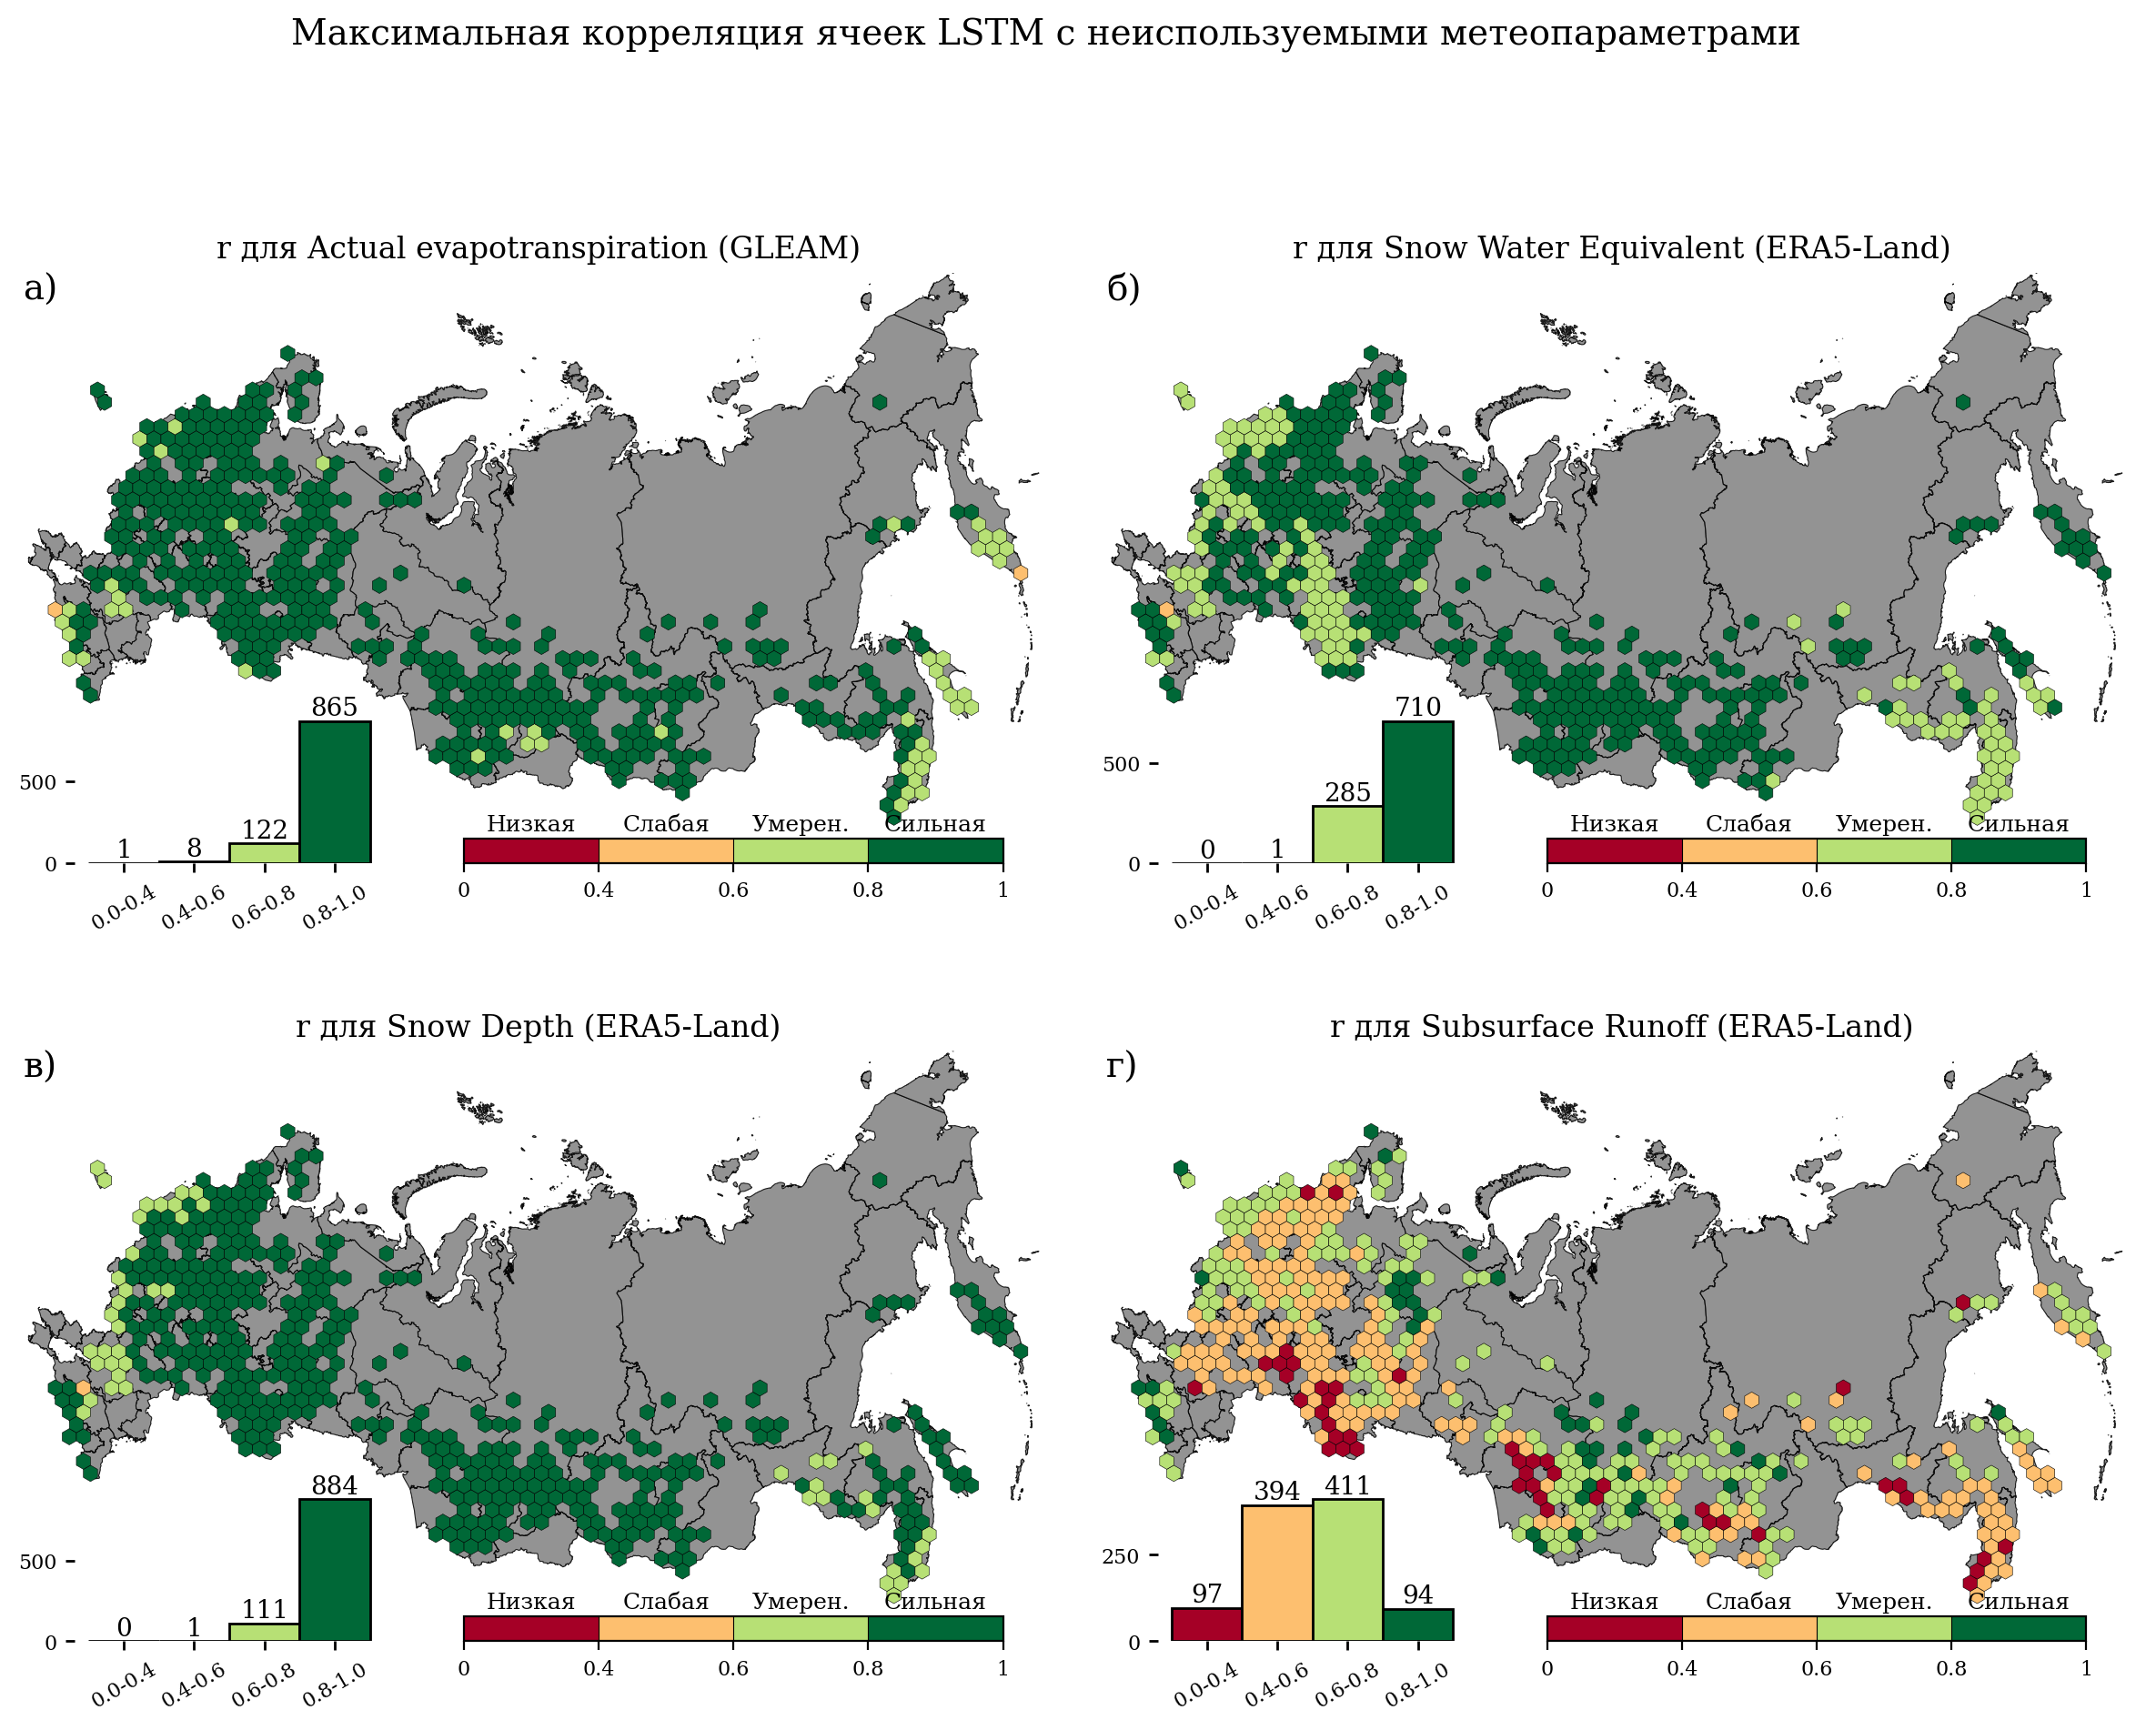

Hex radius: 66.0 km


In [15]:
# =============================================================================
# Create spatial hex maps for best correlations
# =============================================================================
metric_cols = [f"r_{p}" for p in METEO_PARAMS.keys()]
title_texts = [f"r для {METEO_PARAMS[p]['description']}" for p in METEO_PARAMS.keys()]

# Filter to gauges with at least one valid correlation
ws_valid = ws_correlations.dropna(subset=metric_cols, how="all")
print(f"Watersheds with valid data: {len(ws_valid)}")

fig, hex_maps, radius_km, coverage_stats = hexes_plots_n(
    watersheds=ws_valid[["geometry"] + metric_cols],
    basemap_data=basemap_data,
    metric_cols=metric_cols,
    label_list=["а)", "б)", "в)", "г)"],
    nrows=2,
    ncols=2,
    target_ws_per_hex=6.0,
    area_weighted=False,
    min_overlap_share=0.15,
    quantile=0.5,
    list_of_limits=[0.0, 0.4, 0.6, 0.8, 1.0],
    figsize=(15, 10),
    basemap_alpha=0.85,
    with_histogram=True,
    cb_label=["Низкая", "Слабая", "Умерен.", "Сильная"],
    title_text=title_texts,
)

plt.suptitle(
    "Максимальная корреляция ячеек LSTM с неиспользуемыми метеопараметрами",
    fontsize=14,
    y=1.02,
)
plt.savefig(
    image_dir / "lstm_states_correlation_hexmap.png", dpi=150, bbox_inches="tight"
)
plt.show()

print(f"Hex radius: {radius_km:.1f} km")

In [16]:
# =============================================================================
# Spatial hex map: Correlation with the GLOBAL best cell for each parameter
# =============================================================================
# For each parameter, find the single cell with highest average correlation across all gauges
# Then map that cell's correlation spatially

ws_global_cell = ws.copy()

for param_name, corr_df in correlation_matrices.items():
    # Find the cell with highest mean absolute correlation across all gauges
    mean_corr = corr_df.abs().mean()
    global_best_cell = mean_corr.idxmax()
    global_best_corr_value = mean_corr.max()

    print(
        f"{param_name}: Global best cell = {global_best_cell} (mean |r| = {global_best_corr_value:.3f})"
    )

    # Get the correlation of this specific cell for each gauge
    cell_corr = corr_df[global_best_cell]
    ws_global_cell[f"r_cell{global_best_cell}_{param_name}"] = cell_corr.reindex(
        ws_global_cell.index
    )

evaporation: Global best cell = 231 (mean |r| = 0.824)
swe: Global best cell = 186 (mean |r| = 0.739)
snow_depth: Global best cell = 143 (mean |r| = 0.813)
subsurface: Global best cell = 65 (mean |r| = 0.407)


Watersheds with valid global cell data: 996


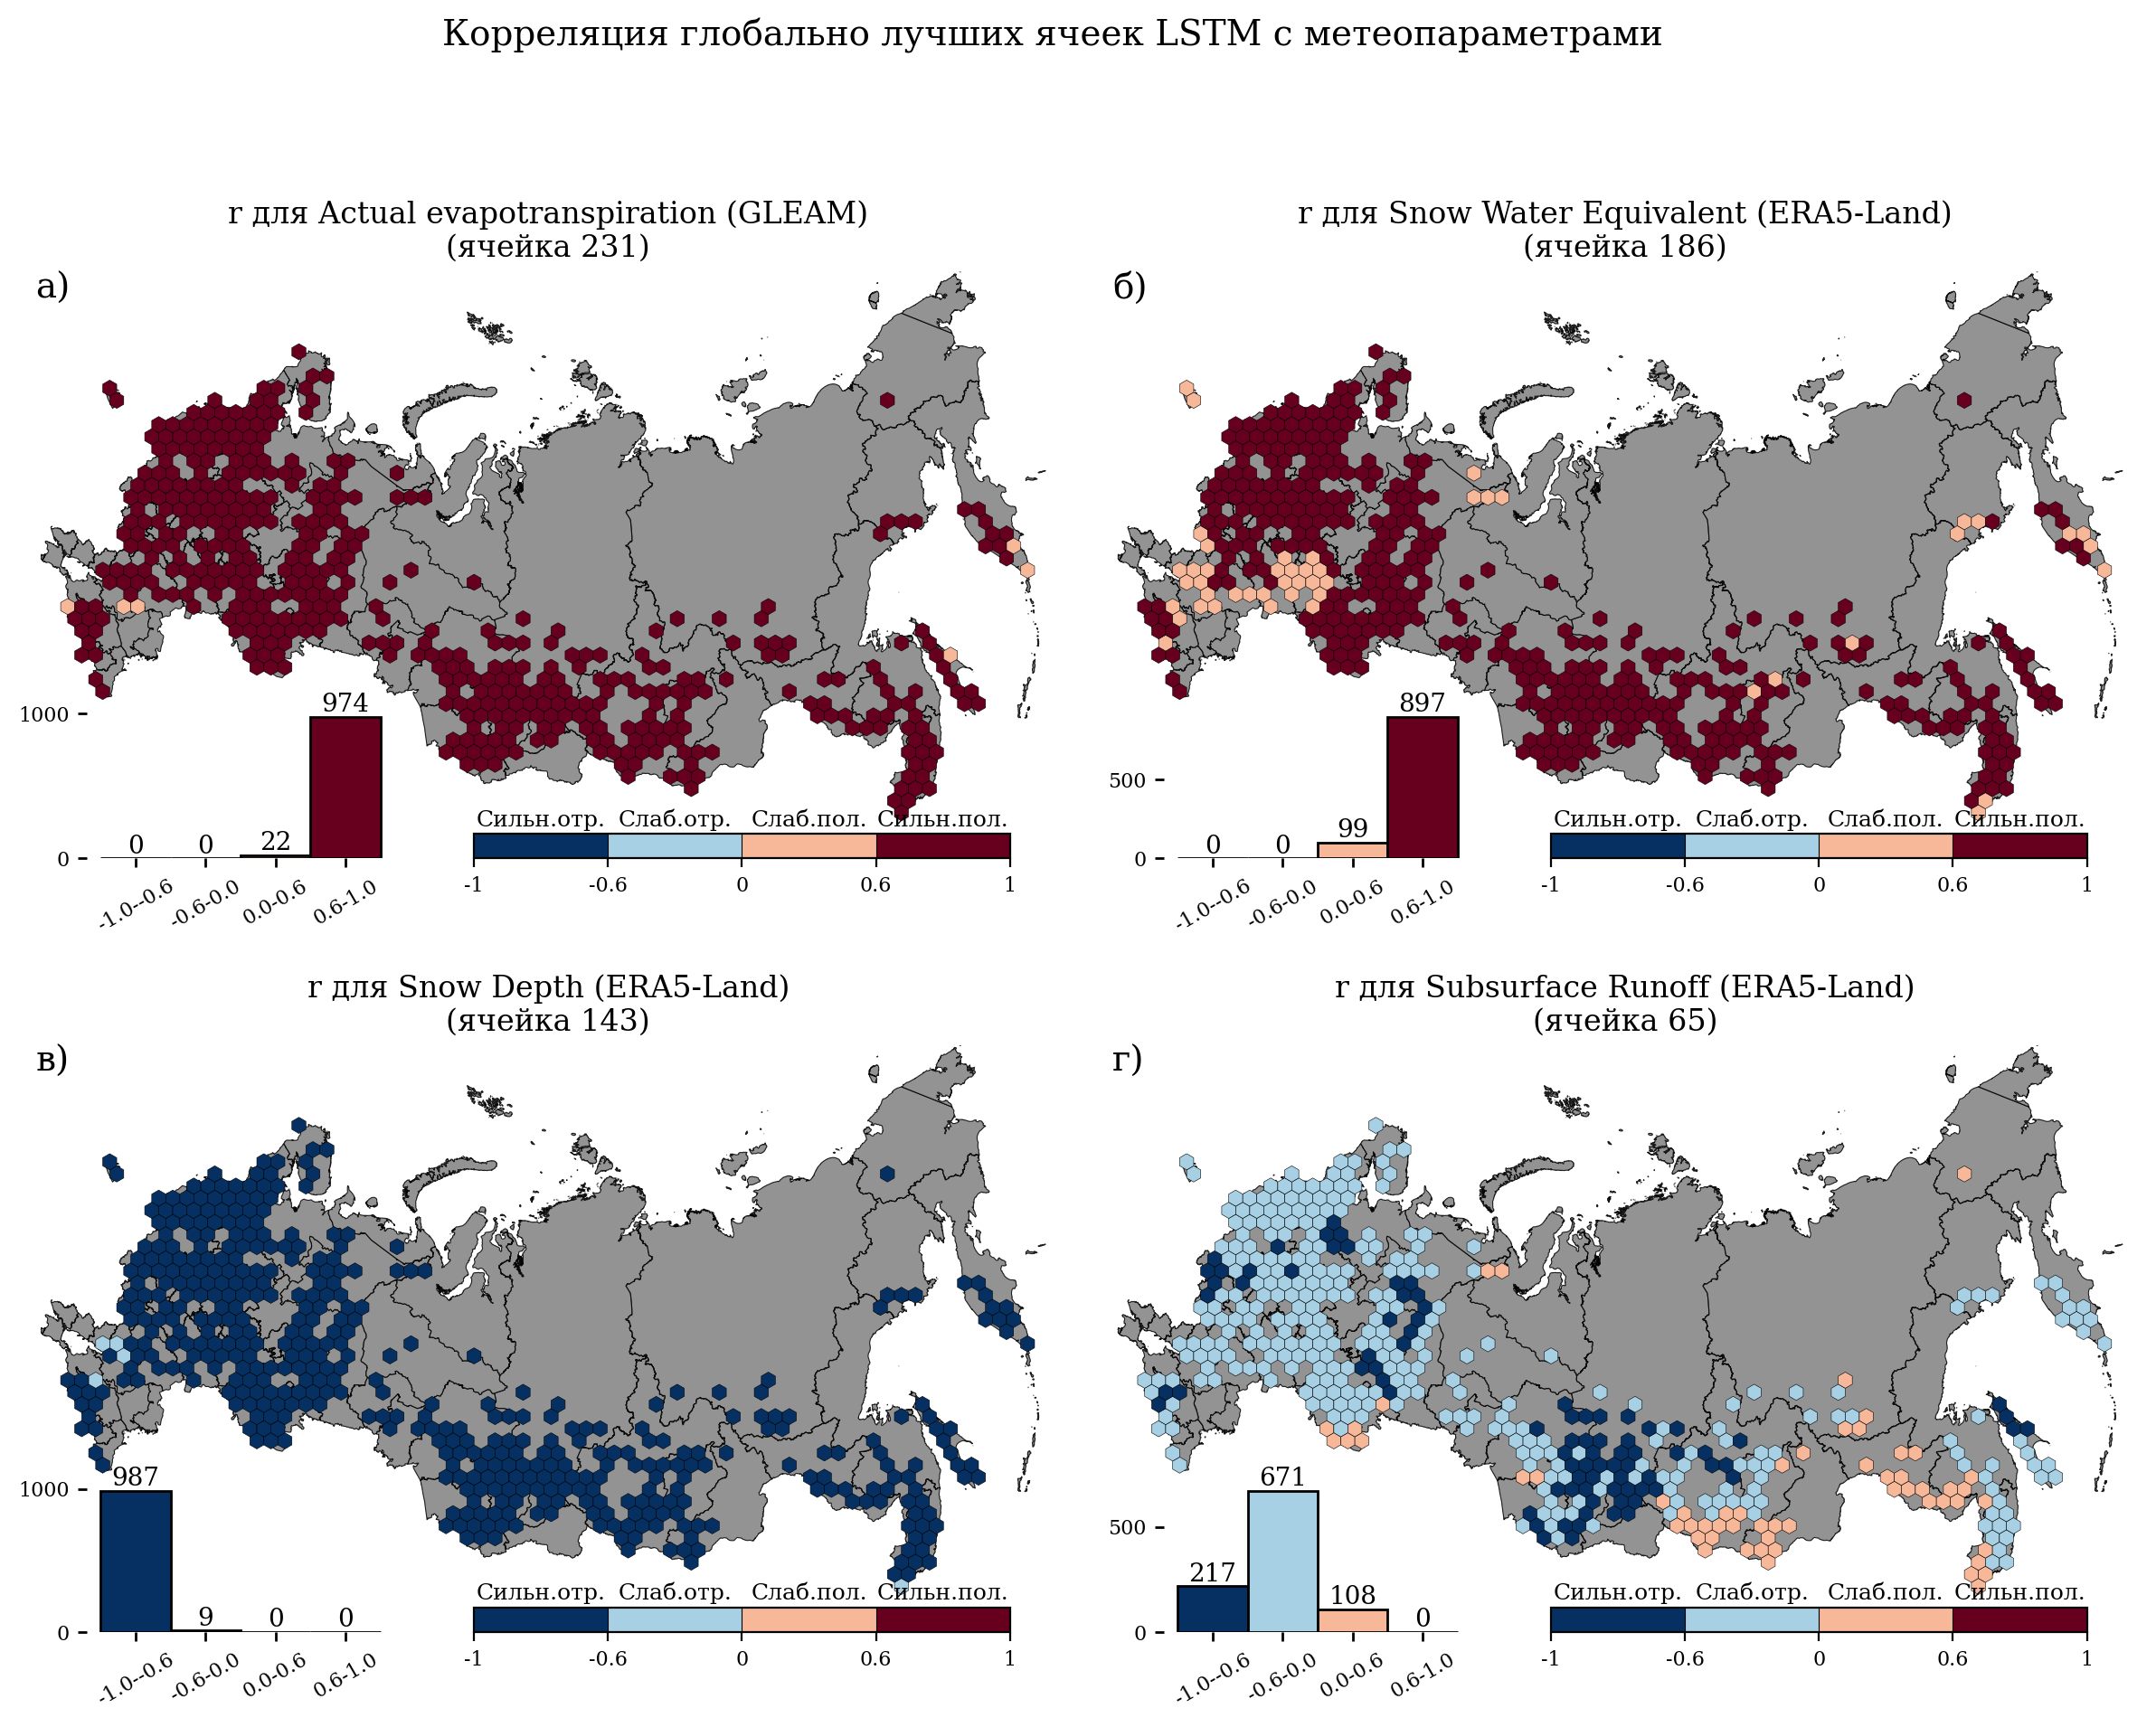

In [17]:
# =============================================================================
# Create hex map for global best cell correlations
# =============================================================================
# Build metric columns and titles dynamically based on discovered best cells
global_metric_cols = []
global_titles = []

for param_name, corr_df in correlation_matrices.items():
    mean_corr = corr_df.abs().mean()
    global_best_cell = mean_corr.idxmax()
    col_name = f"r_cell{global_best_cell}_{param_name}"

    if col_name in ws_global_cell.columns:
        global_metric_cols.append(col_name)
        global_titles.append(
            f"r для {METEO_PARAMS[param_name]['description']}\n(ячейка {global_best_cell})"
        )

ws_global_valid = ws_global_cell.dropna(subset=global_metric_cols, how="all")
print(f"Watersheds with valid global cell data: {len(ws_global_valid)}")

if len(global_metric_cols) == 4:
    fig, hex_maps2, radius_km2, coverage_stats2 = hexes_plots_n(
        watersheds=ws_global_valid[["geometry"] + global_metric_cols],
        basemap_data=basemap_data,
        metric_cols=global_metric_cols,
        label_list=["а)", "б)", "в)", "г)"],
        nrows=2,
        ncols=2,
        target_ws_per_hex=6.0,
        area_weighted=False,
        min_overlap_share=0.15,
        quantile=0.5,
        list_of_limits=[-1.0, -0.6, 0.0, 0.6, 1.0],  # Symmetric around 0
        cmap_name="RdBu_r",
        figsize=(15, 10),
        basemap_alpha=0.85,
        with_histogram=True,
        cb_label=["Сильн.отр.", "Слаб.отр.", "Слаб.пол.", "Сильн.пол."],
        title_text=global_titles,
    )

    plt.suptitle(
        "Корреляция глобально лучших ячеек LSTM с метеопараметрами",
        fontsize=14,
        y=1.02,
    )
    plt.savefig(
        image_dir / "lstm_global_best_cell_hexmap.png", dpi=150, bbox_inches="tight"
    )
    plt.show()
else:
    print(f"Not enough parameters for 2x2 plot: {len(global_metric_cols)}")

In [18]:
# =============================================================================
# Summary: Regional Patterns in LSTM Cell Specialization
# =============================================================================
print("=" * 70)
print("SUMMARY: LSTM Hidden State Representation of Unused Meteo Parameters")
print("=" * 70)

for param_name, corr_df in correlation_matrices.items():
    if len(corr_df) == 0:
        continue

    # Overall statistics
    mean_max_corr = corr_df.abs().max(axis=1).mean()

    # Global best cell
    mean_corr = corr_df.abs().mean()
    global_best_cell = mean_corr.idxmax()
    global_best_value = mean_corr.max()

    # How many gauges have correlation > 0.5 with this cell?
    strong_corr_count = (corr_df[global_best_cell].abs() > 0.5).sum()

    print(f"\n{param_name.upper()}:")
    print(f"  Average best correlation: {mean_max_corr:.3f}")
    print(f"  Global best cell: {global_best_cell}")
    print(f"  Mean |r| for cell {global_best_cell}: {global_best_value:.3f}")
    print(f"  Gauges with |r| > 0.5 for this cell: {strong_corr_count} / {len(corr_df)}")

print("\n" + "=" * 70)
print("INTERPRETATION:")
print("=" * 70)
print("""
- Higher average correlations indicate the LSTM learns to represent that process
- Global best cells are those that consistently encode a process across regions
- Strong spatial patterns suggest the LSTM uses similar internal representations
  for gauges with similar physical/hydrological characteristics
""")

SUMMARY: LSTM Hidden State Representation of Unused Meteo Parameters

EVAPORATION:
  Average best correlation: 0.834
  Global best cell: 231
  Mean |r| for cell 231: 0.824
  Gauges with |r| > 0.5 for this cell: 993 / 996

SWE:
  Average best correlation: 0.834
  Global best cell: 186
  Mean |r| for cell 186: 0.739
  Gauges with |r| > 0.5 for this cell: 976 / 996

SNOW_DEPTH:
  Average best correlation: 0.864
  Global best cell: 143
  Mean |r| for cell 143: 0.813
  Gauges with |r| > 0.5 for this cell: 996 / 996

SUBSURFACE:
  Average best correlation: 0.602
  Global best cell: 65
  Mean |r| for cell 65: 0.407
  Gauges with |r| > 0.5 for this cell: 377 / 996

INTERPRETATION:

- Higher average correlations indicate the LSTM learns to represent that process
- Global best cells are those that consistently encode a process across regions
- Strong spatial patterns suggest the LSTM uses similar internal representations
  for gauges with similar physical/hydrological characteristics



## Cell Group Assignment

Assign each LSTM cell to a process group based on which meteorological parameter it correlates with most strongly.

In [19]:
# =============================================================================
# Define Cell Groups by Process (EXCLUSIVE assignment - no overlap)
# =============================================================================
# Strategy:
# - Each cell is assigned to exactly ONE process (the one with highest correlation)
# - All 4 processes (evaporation, swe, snow_depth, subsurface) are kept SEPARATE
# - Cells with correlation < threshold are marked "inactive"

MIN_CORRELATION = 0.3  # Cells with lower correlation are "inactive"

# Build a DataFrame: cell_id x param -> mean absolute correlation
cell_process_matrix = pd.DataFrame(index=range(hidden_size))

for param_name, corr_df in correlation_matrices.items():
    # Mean absolute correlation for each cell across all gauges
    mean_abs_corr = corr_df.abs().mean()
    cell_process_matrix[param_name] = mean_abs_corr.values

# Determine primary process for each cell (EXCLUSIVE - highest correlation wins)
all_params = list(METEO_PARAMS.keys())
cell_process_matrix["max_corr"] = cell_process_matrix[all_params].max(axis=1)
cell_process_matrix["primary_process"] = cell_process_matrix[all_params].idxmax(axis=1)

# Mark inactive cells
cell_process_matrix.loc[
    cell_process_matrix["max_corr"] < MIN_CORRELATION, "primary_process"
] = "inactive"

# Create cell groups dictionary - EXCLUSIVE assignment
cell_groups = {param: [] for param in all_params}
cell_groups["inactive"] = []

for cell_id in range(hidden_size):
    primary = cell_process_matrix.loc[cell_id, "primary_process"]
    if primary in cell_groups:
        cell_groups[primary].append(cell_id)

# Display results
print("=" * 70)
print("CELL GROUPS BY PROCESS (EXCLUSIVE assignment - no overlap)")
print("=" * 70)

for process in all_params + ["inactive"]:
    cells = cell_groups[process]
    n_cells = len(cells)
    if n_cells > 0 and process != "inactive":
        avg_corr = cell_process_matrix.loc[cells, process].mean()
        top_cells = cell_process_matrix.loc[cells].nlargest(10, process).index.tolist()
        print(f"\n{process.upper()} ({n_cells} cells):")
        print(f"  Average |r|: {avg_corr:.3f}")
        print(f"  Top 10 cell IDs: {top_cells}")
    elif process == "inactive":
        print(f"\nINACTIVE ({n_cells} cells) - correlation < {MIN_CORRELATION}")

# Verify no overlap
all_assigned = []
for p, cells in cell_groups.items():
    all_assigned.extend(cells)
print(f"\nTotal cells assigned: {len(all_assigned)} (should be {hidden_size})")
print(f"Unique cells: {len(set(all_assigned))} (confirms no overlap)")

CELL GROUPS BY PROCESS (EXCLUSIVE assignment - no overlap)

EVAPORATION (147 cells):
  Average |r|: 0.597
  Top 10 cell IDs: [231, 0, 50, 59, 38, 115, 86, 156, 164, 239]

SWE (15 cells):
  Average |r|: 0.514
  Top 10 cell IDs: [225, 184, 170, 149, 236, 181, 107, 241, 196, 110]

SNOW_DEPTH (57 cells):
  Average |r|: 0.638
  Top 10 cell IDs: [143, 56, 186, 197, 117, 17, 245, 224, 41, 83]

SUBSURFACE (4 cells):
  Average |r|: 0.320
  Top 10 cell IDs: [189, 89, 146, 20]

INACTIVE (33 cells) - correlation < 0.3

Total cells assigned: 256 (should be 256)
Unique cells: 256 (confirms no overlap)


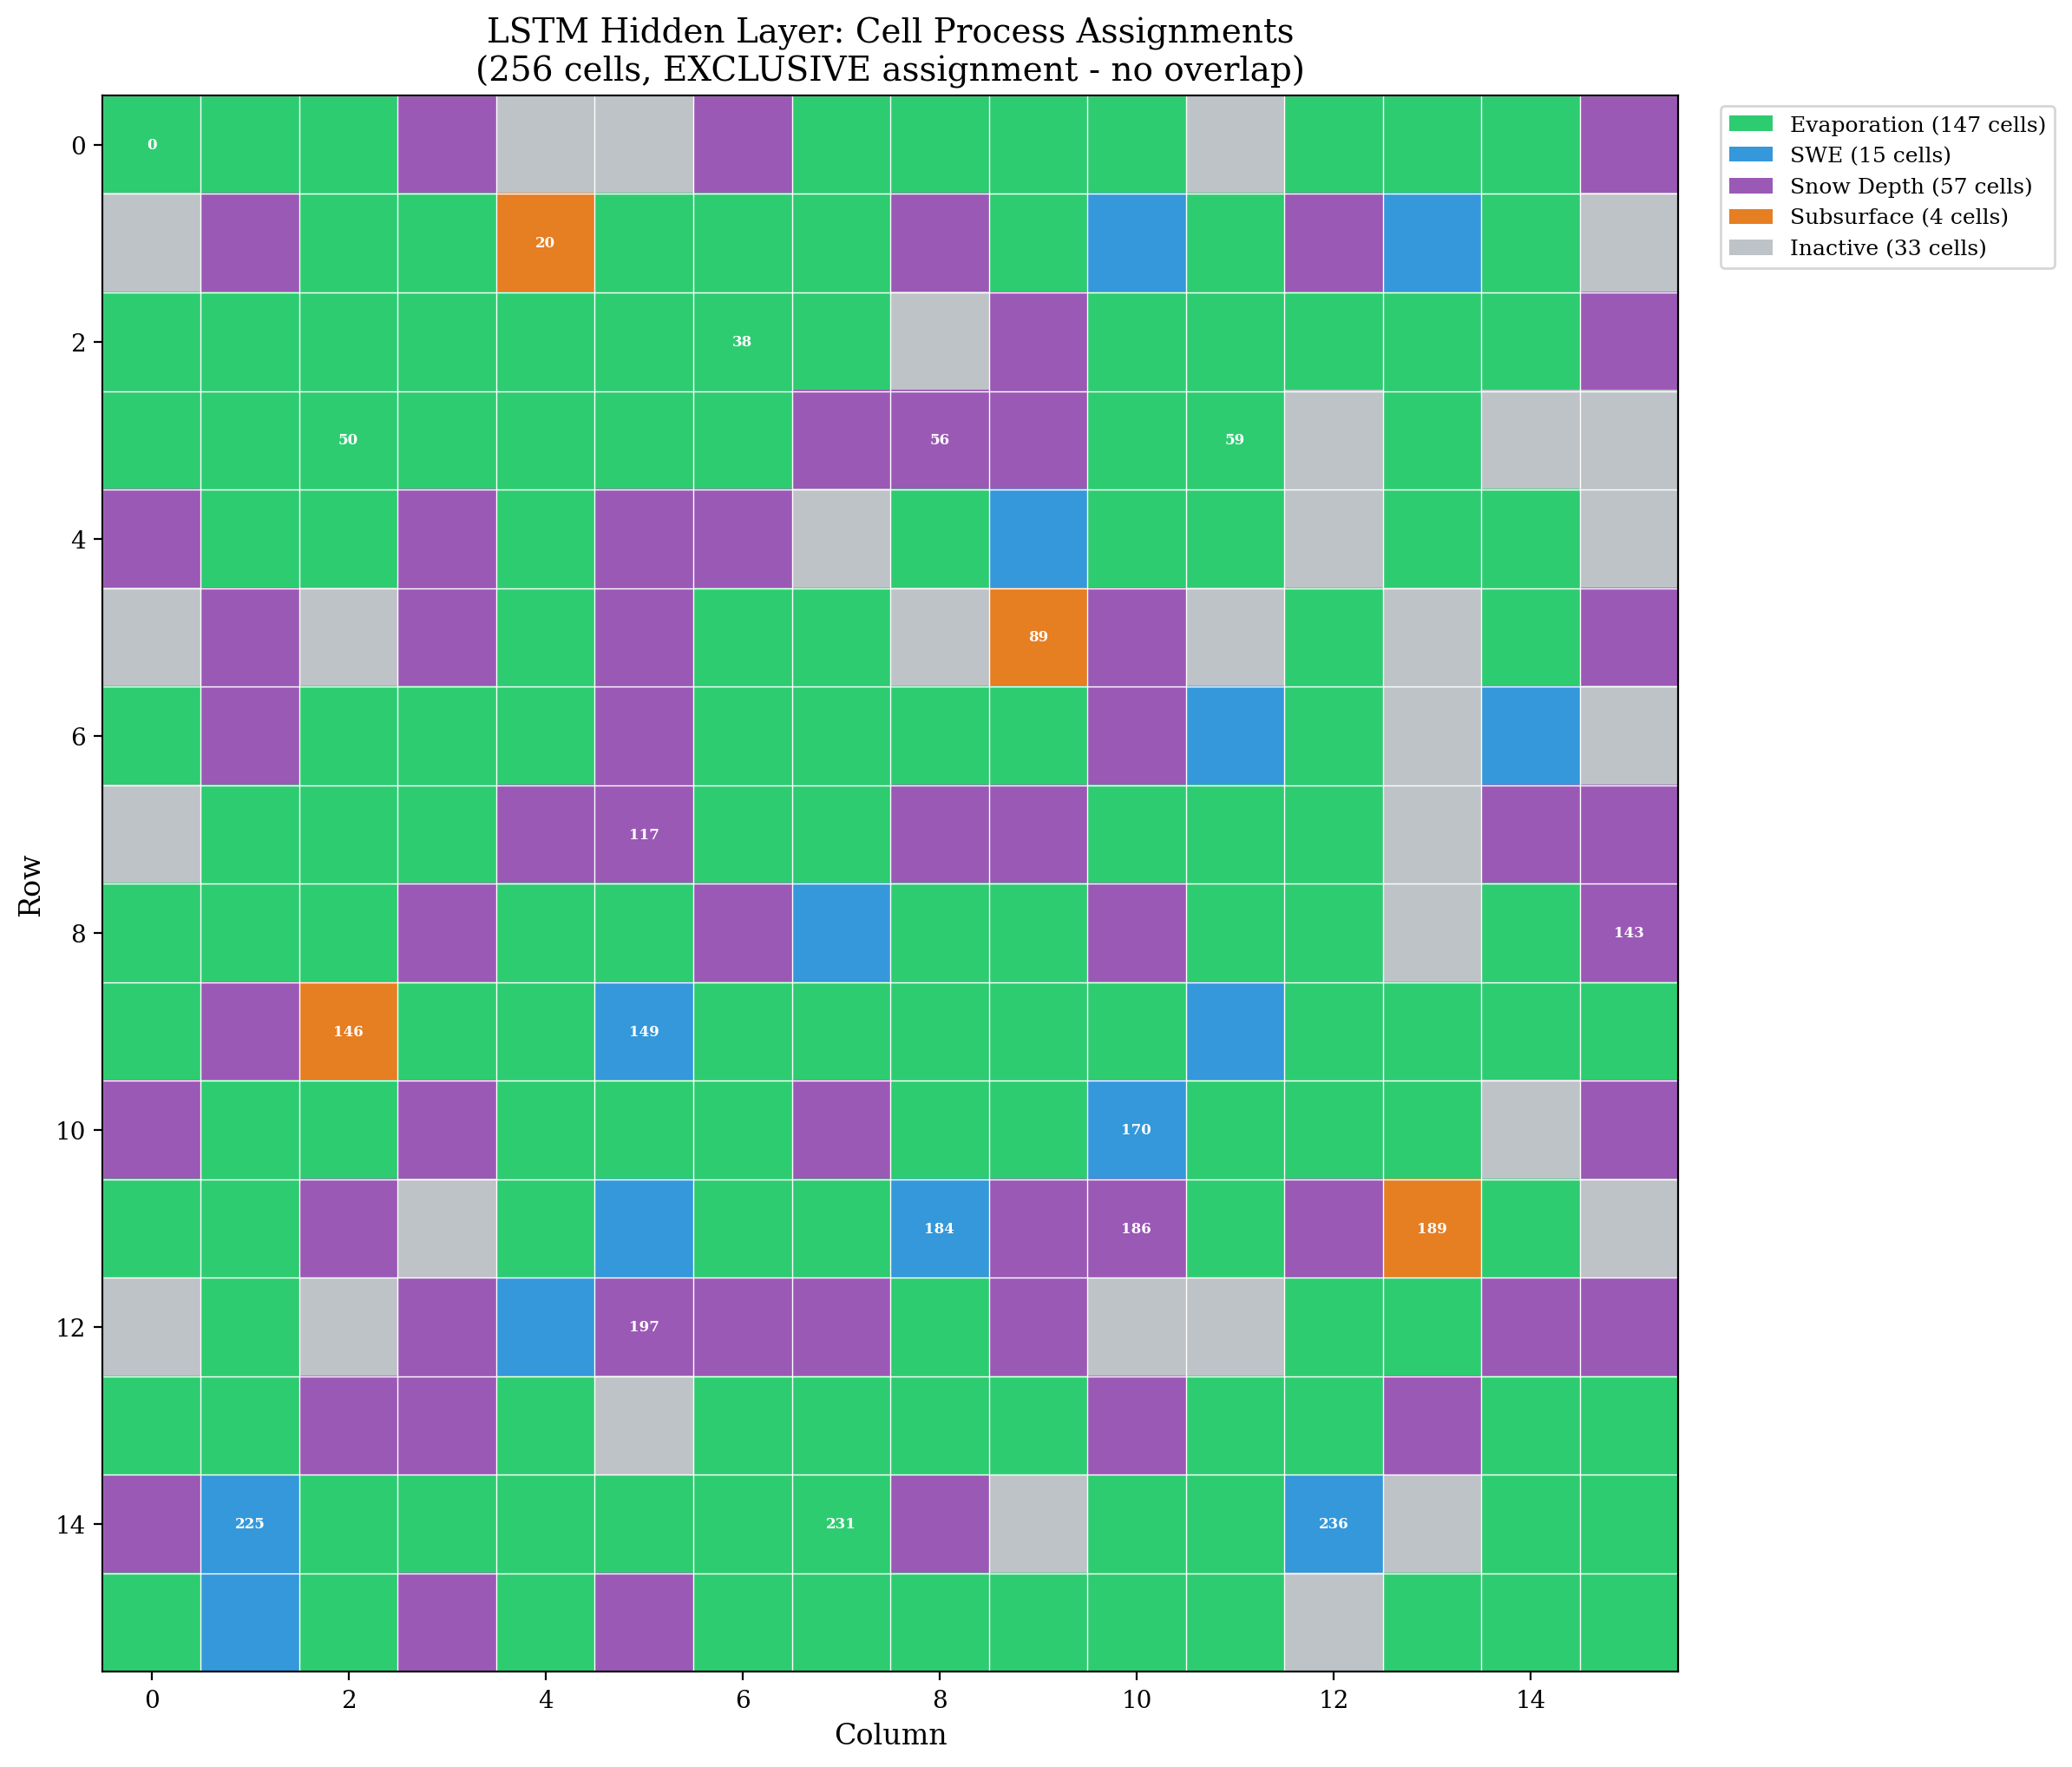

In [20]:
# =============================================================================
# Visualize Cell Groups as a Grid Map of LSTM Hidden Layer
# =============================================================================
# Create a 16x16 grid representing the 256 cells, colored by their primary process
# All 4 processes have EXCLUSIVE cell assignment (no overlap)

# Colors for each process (all distinct)
process_colors = {
    "evaporation": "#2ecc71",  # Green
    "swe": "#3498db",  # Blue
    "snow_depth": "#9b59b6",  # Purple
    "subsurface": "#e67e22",  # Orange
    "inactive": "#bdc3c7",  # Gray
}

fig, ax = plt.subplots(figsize=(12, 12))

# Reshape cell assignments into 16x16 grid
grid_size = int(np.sqrt(hidden_size))
if grid_size * grid_size != hidden_size:
    grid_size = 16  # Fallback

cell_grid = np.zeros((grid_size, grid_size, 3))
cell_texts = []

for i in range(hidden_size):
    row = i // grid_size
    col = i % grid_size
    process = cell_process_matrix.loc[i, "primary_process"]
    color_hex = process_colors.get(process, "#bdc3c7")
    # Convert hex to RGB
    rgb = tuple(int(color_hex.lstrip("#")[j : j + 2], 16) / 255 for j in (0, 2, 4))
    cell_grid[row, col] = rgb

ax.imshow(cell_grid, aspect="equal")

# Add grid lines
for i in range(grid_size + 1):
    ax.axhline(i - 0.5, color="white", linewidth=0.5)
    ax.axvline(i - 0.5, color="white", linewidth=0.5)

# Add cell indices for top cells of each process group
for process in ["evaporation", "swe", "snow_depth", "subsurface"]:
    cells = cell_groups.get(process, [])
    if len(cells) == 0 or process not in cell_process_matrix.columns:
        continue

    top_cells = cell_process_matrix.loc[cells].nlargest(5, process).index.tolist()
    for cell_id in top_cells:
        row = cell_id // grid_size
        col = cell_id % grid_size
        ax.text(
            col,
            row,
            str(cell_id),
            ha="center",
            va="center",
            fontsize=6,
            color="white",
            fontweight="bold",
        )

ax.set_xlabel("Column", fontsize=12)
ax.set_ylabel("Row", fontsize=12)
ax.set_title(
    "LSTM Hidden Layer: Cell Process Assignments\n(256 cells, EXCLUSIVE assignment - no overlap)",
    fontsize=14,
)

# Legend - show all 4 process groups
legend_elements = [
    plt.Rectangle(
        (0, 0),
        1,
        1,
        facecolor=process_colors["evaporation"],
        label=f"Evaporation ({len(cell_groups['evaporation'])} cells)",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        facecolor=process_colors["swe"],
        label=f"SWE ({len(cell_groups['swe'])} cells)",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        facecolor=process_colors["snow_depth"],
        label=f"Snow Depth ({len(cell_groups['snow_depth'])} cells)",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        facecolor=process_colors["subsurface"],
        label=f"Subsurface ({len(cell_groups['subsurface'])} cells)",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        facecolor=process_colors["inactive"],
        label=f"Inactive ({len(cell_groups['inactive'])} cells)",
    ),
]
ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=9)

plt.tight_layout()
plt.savefig(image_dir / "lstm_cell_groups_grid.png", dpi=150, bbox_inches="tight")
plt.show()

In [21]:
# =============================================================================
# Determine Dominant Process for Each Gauge
# =============================================================================
# For each gauge, find which process the LSTM represents most strongly
# by comparing the best correlation across all cells for each parameter

gauge_dominant_process = pd.DataFrame(index=common_index)

for param_name, corr_df in correlation_matrices.items():
    # Best correlation for each gauge (max across all cells)
    best_corr = corr_df.abs().max(axis=1)
    gauge_dominant_process[f"best_r_{param_name}"] = best_corr

# Find the dominant process for each gauge
param_cols = [f"best_r_{p}" for p in METEO_PARAMS.keys()]
gauge_dominant_process = gauge_dominant_process.dropna(how="all")

gauge_dominant_process["dominant_process"] = gauge_dominant_process[param_cols].idxmax(
    axis=1
)
gauge_dominant_process["dominant_process"] = gauge_dominant_process[
    "dominant_process"
].str.replace("best_r_", "")
gauge_dominant_process["max_correlation"] = gauge_dominant_process[param_cols].max(axis=1)

# Keep all 4 processes SEPARATE (no merging)
# Convert to numeric codes for mapping
process_to_code = {"evaporation": 1, "swe": 2, "snow_depth": 3, "subsurface": 4}
gauge_dominant_process["process_code"] = gauge_dominant_process["dominant_process"].map(
    process_to_code
)

# Summary
print("Dominant process distribution (all 4 processes separate):")
print(gauge_dominant_process["dominant_process"].value_counts())

Dominant process distribution (all 4 processes separate):
dominant_process
snow_depth     647
evaporation    264
swe             84
subsurface       1
Name: count, dtype: int64


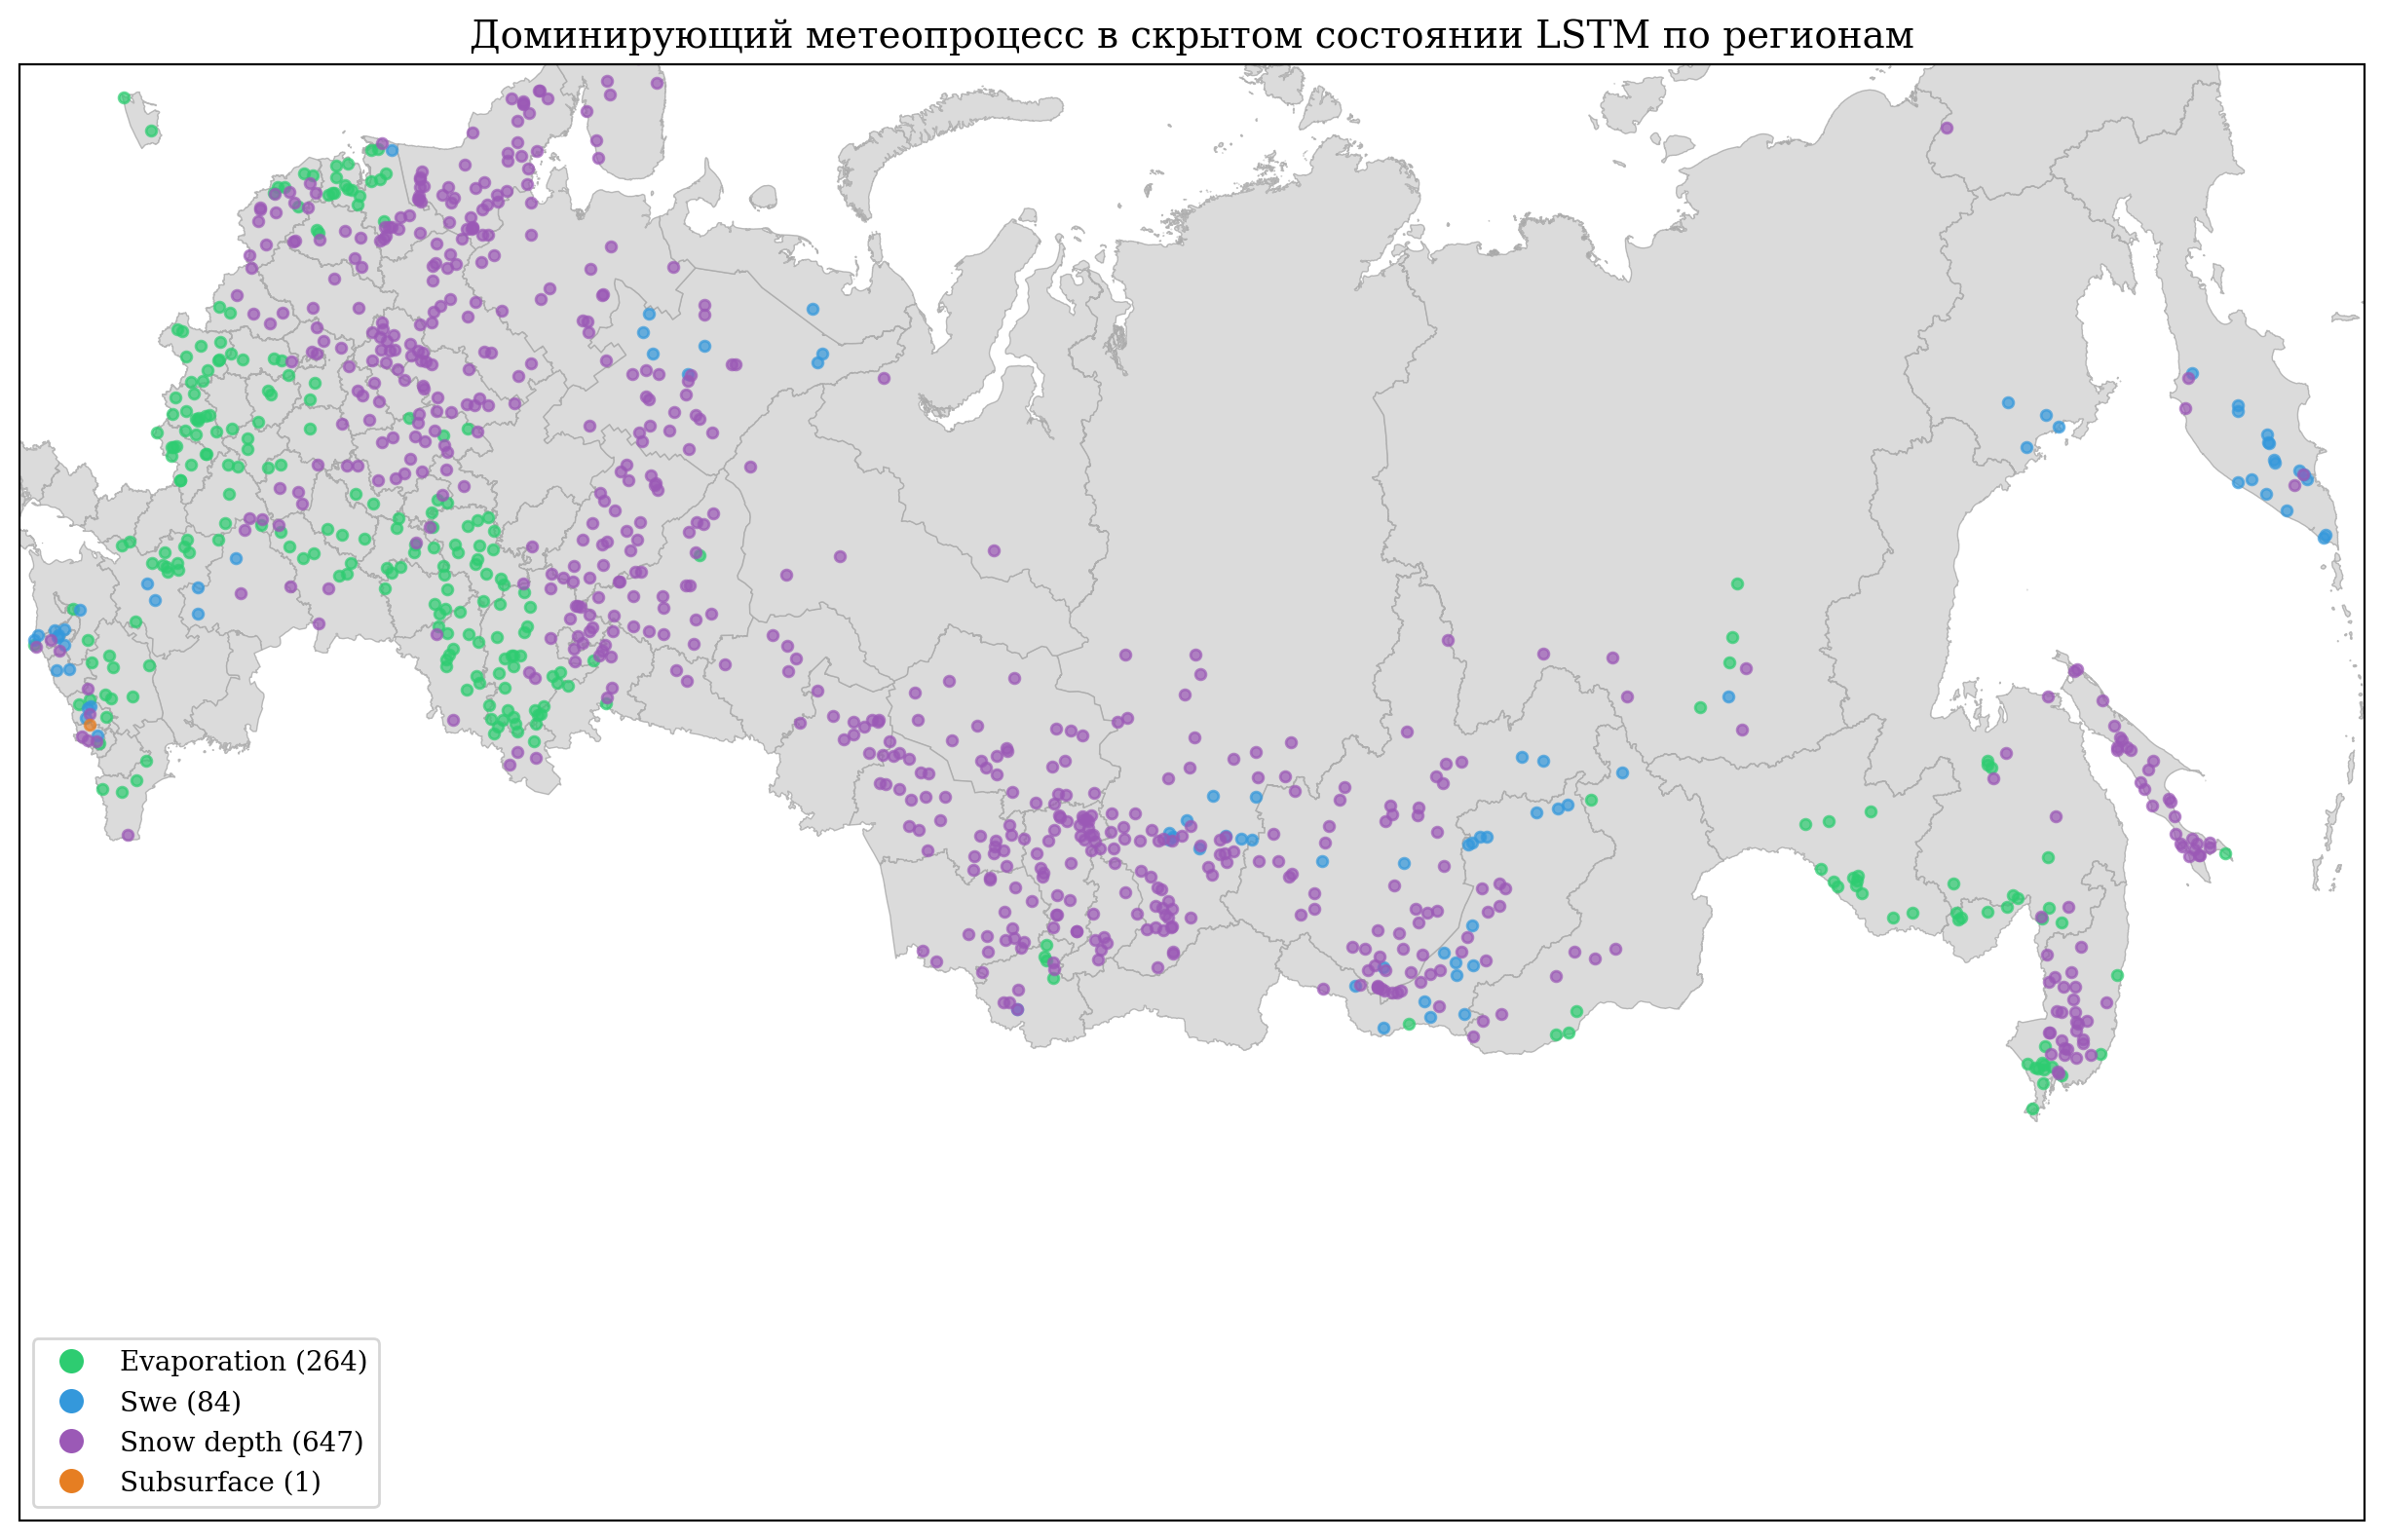

In [22]:
# =============================================================================
# Spatial Map: Dominant Process by Region (Point Map)
# =============================================================================
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

# Merge with gauge geometries
gauges_process = gauges.copy()
gauges_process = gauges_process.join(
    gauge_dominant_process[["dominant_process", "max_correlation"]], how="inner"
)

# Create figure
fig, ax = plt.subplots(
    figsize=(14, 8),
    subplot_kw={
        "projection": ccrs.AlbersEqualArea(
            central_longitude=100,
            standard_parallels=(50, 70),
            central_latitude=56,
        )
    },
)

# Plot basemap
basemap_data.to_crs(ax.projection.proj4_init).plot(
    ax=ax, color="lightgray", edgecolor="darkgray", linewidth=0.5, alpha=0.8
)

# Plot gauges colored by dominant process
for process, color in process_colors.items():
    if process == "inactive":
        continue
    subset = gauges_process[gauges_process["dominant_process"] == process]
    if len(subset) > 0:
        subset.to_crs(ax.projection.proj4_init).plot(
            ax=ax,
            color=color,
            markersize=15,
            alpha=0.7,
            label=f"{process.capitalize()} ({len(subset)})",
        )

# Legend - all 4 process groups
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=process_colors[p],
        markersize=10,
        label=f"{p.replace('_', ' ').capitalize()} ({len(gauges_process[gauges_process['dominant_process'] == p])})",
    )
    for p in ["evaporation", "swe", "snow_depth", "subsurface"]
    if p in gauges_process["dominant_process"].values
]
ax.legend(handles=legend_elements, loc="lower left", fontsize=10)

ax.set_title(
    "Доминирующий метеопроцесс в скрытом состоянии LSTM по регионам", fontsize=14
)
ax.set_extent([50, 140, 35, 75], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.savefig(image_dir / "lstm_dominant_process_map.png", dpi=150, bbox_inches="tight")
plt.show()

In [23]:
# =============================================================================
# Spatial Hex Map: Process Correlation Strength by Cell Groups
# Create 4 maps for EXCLUSIVE process groups (no overlap)
# =============================================================================
# Prepare watershed data with correlations for each process group
ws_process_corr = ws.copy()

# For each process, use ONLY the cells assigned to that process (exclusive)
for param_name, corr_df in correlation_matrices.items():
    process_cells = cell_groups.get(param_name, [])
    col_name = f"group_r_{param_name}"

    if len(process_cells) > 0:
        # Average correlation using only the cells assigned to this process
        ws_process_corr[col_name] = (
            corr_df[process_cells].abs().mean(axis=1).reindex(ws_process_corr.index)
        )
    else:
        # Fallback: use best correlation across all cells
        ws_process_corr[col_name] = (
            corr_df.abs().max(axis=1).reindex(ws_process_corr.index)
        )

# Create hex maps with 4 separate process groups
group_metric_cols = [f"group_r_{p}" for p in METEO_PARAMS.keys()]
group_titles = []
for p in METEO_PARAMS.keys():
    n_cells = len(cell_groups.get(p, []))
    group_titles.append(f"{METEO_PARAMS[p]['description']}\n({n_cells} ячеек)")

ws_group_valid = ws_process_corr.dropna(subset=group_metric_cols, how="all")
print(f"Watersheds with valid group data: {len(ws_group_valid)}")

Watersheds with valid group data: 996


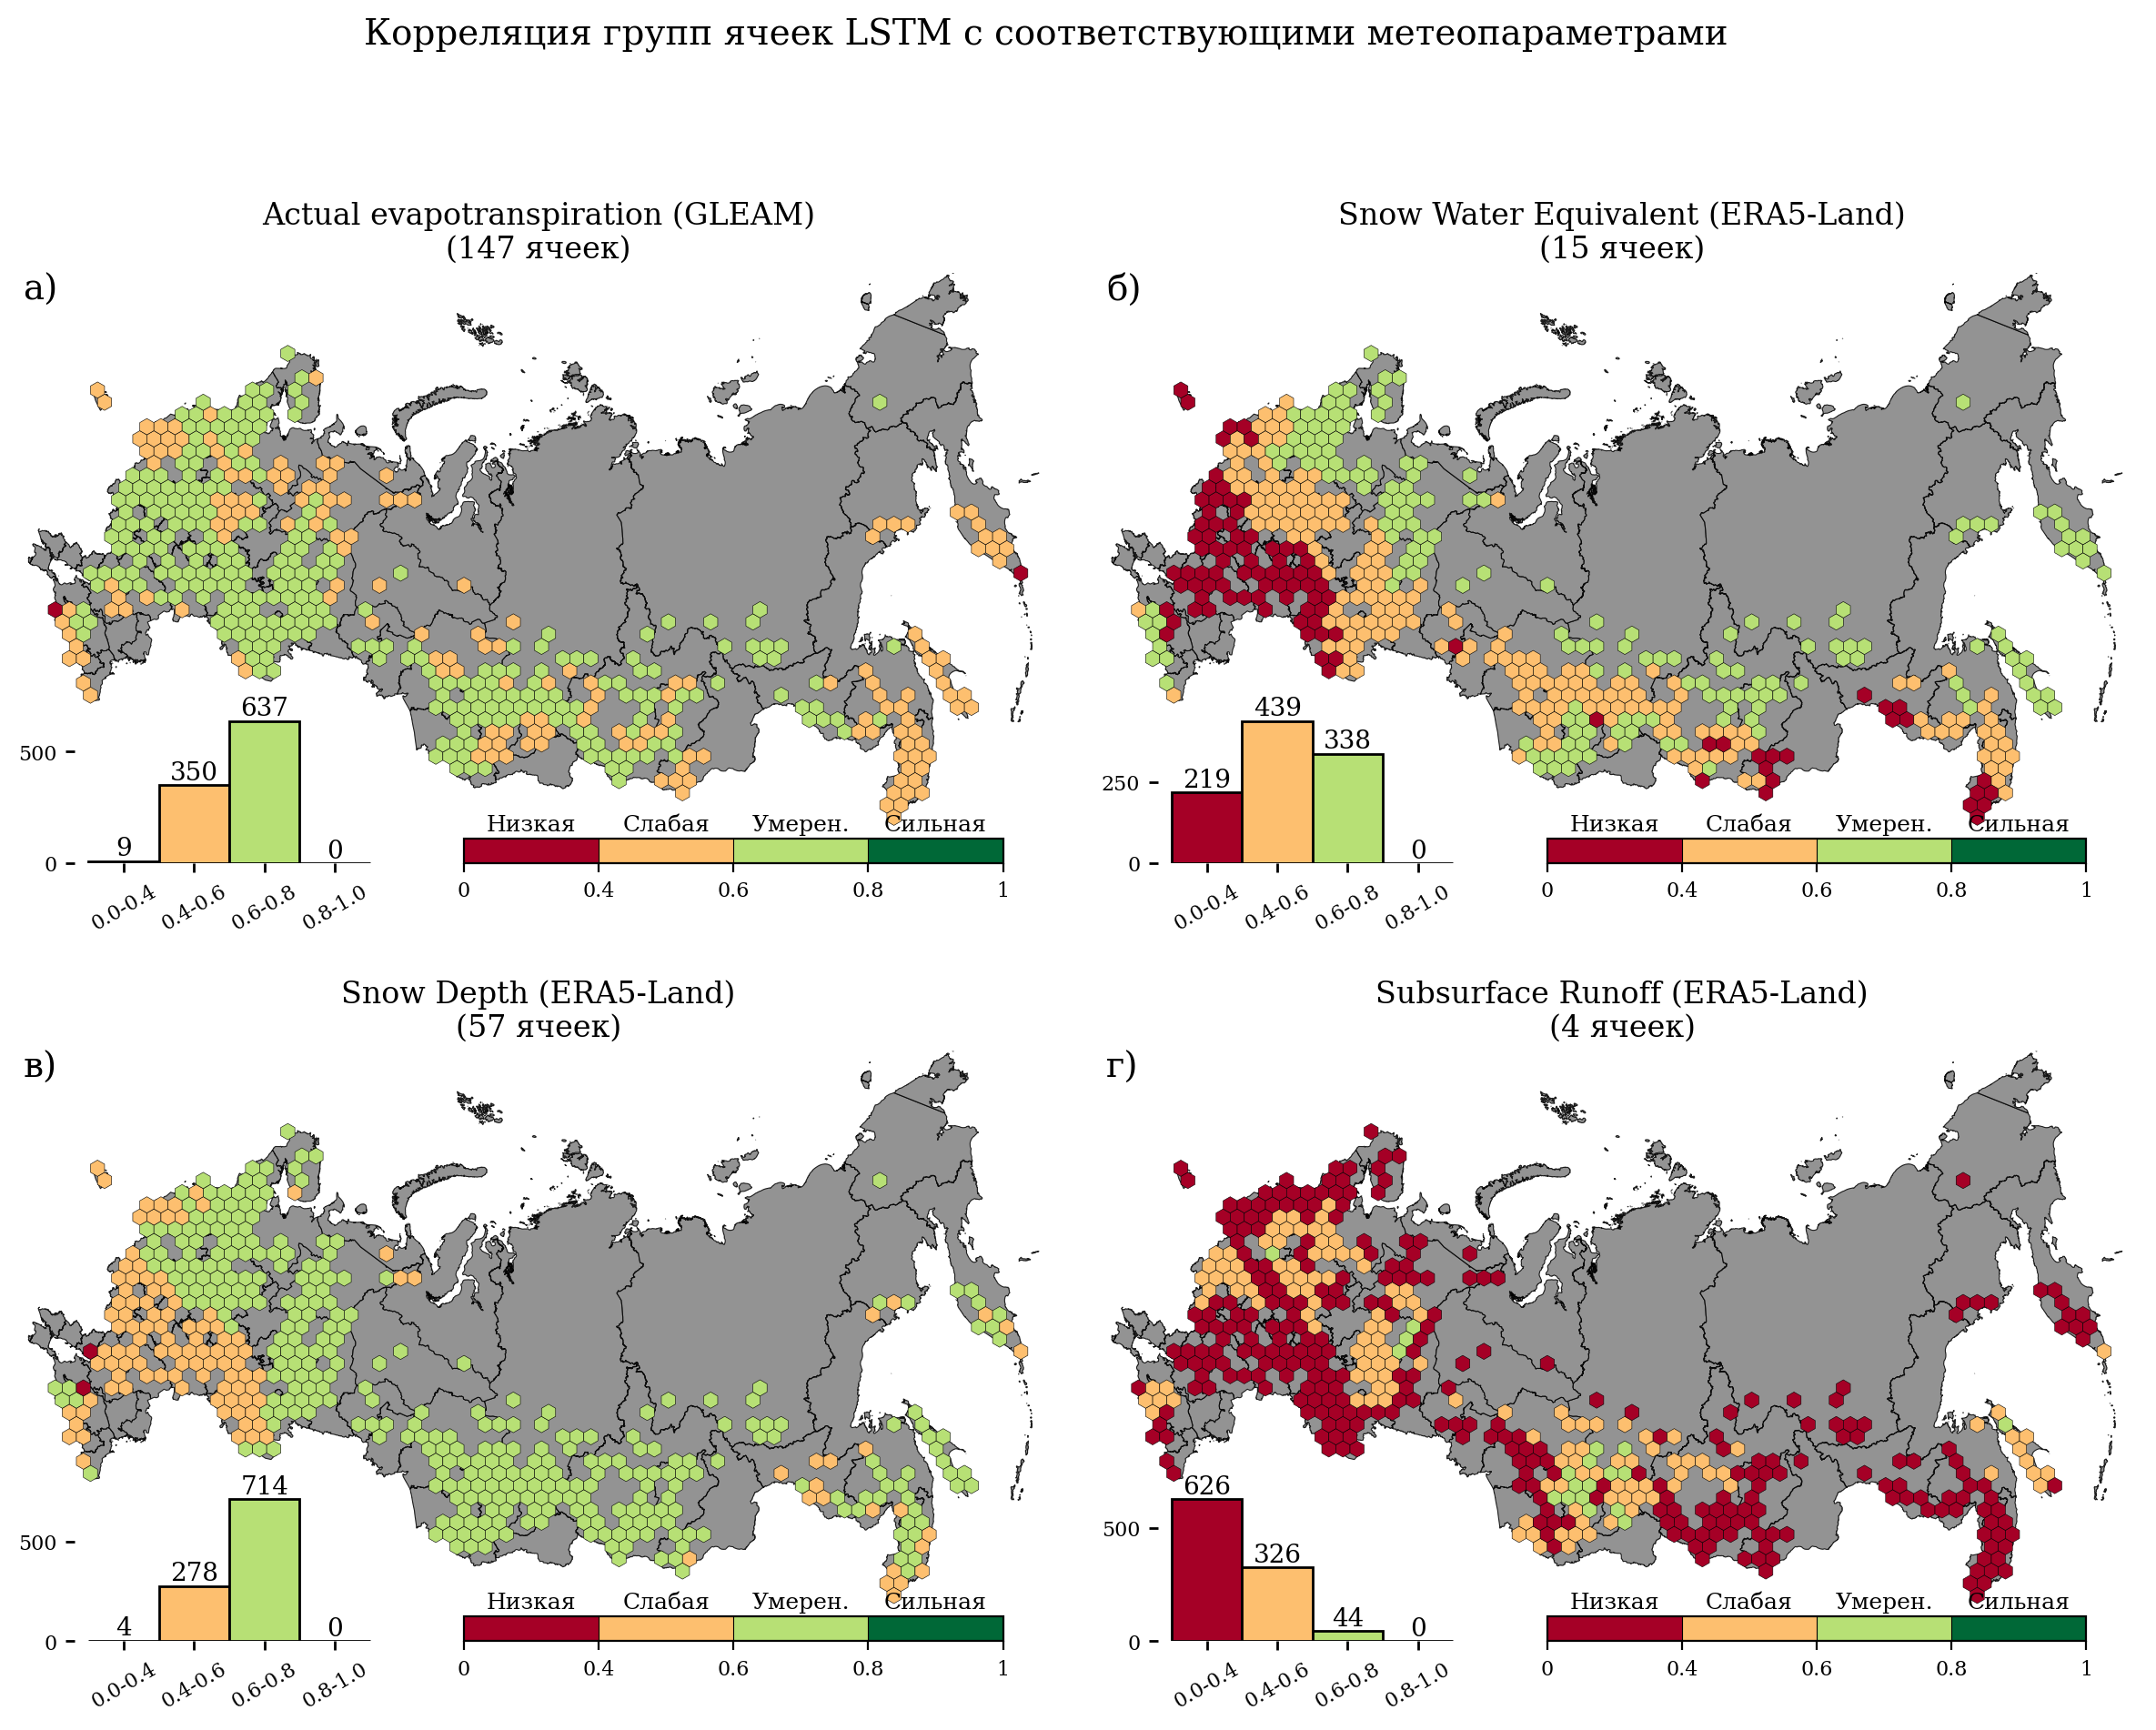

In [24]:
# =============================================================================
# Hex Map: Correlation strength of cell GROUPS
# =============================================================================
if len(group_metric_cols) == 4 and len(ws_group_valid) > 0:
    fig, hex_maps3, radius_km3, coverage_stats3 = hexes_plots_n(
        watersheds=ws_group_valid[["geometry"] + group_metric_cols],
        basemap_data=basemap_data,
        metric_cols=group_metric_cols,
        label_list=["а)", "б)", "в)", "г)"],
        nrows=2,
        ncols=2,
        target_ws_per_hex=6.0,
        area_weighted=False,
        min_overlap_share=0.15,
        quantile=0.5,
        list_of_limits=[0.0, 0.4, 0.6, 0.8, 1.0],
        figsize=(15, 10),
        basemap_alpha=0.85,
        with_histogram=True,
        cb_label=["Низкая", "Слабая", "Умерен.", "Сильная"],
        title_text=group_titles,
    )

    plt.suptitle(
        "Корреляция групп ячеек LSTM с соответствующими метеопараметрами",
        fontsize=14,
        y=1.02,
    )
    plt.savefig(
        image_dir / "lstm_cell_groups_correlation_hexmap.png",
        dpi=150,
        bbox_inches="tight",
    )
    plt.show()
else:
    print("Cannot create hex map: not enough valid data")

In [25]:
# =============================================================================
# Save Cell Groups to File
# =============================================================================
# Create a summary DataFrame for cell groups
cell_groups_summary = []

for process, cells in cell_groups.items():
    for cell_id in cells:
        corr_value = (
            cell_process_matrix.loc[cell_id, process]
            if process in cell_process_matrix.columns
            else np.nan
        )
        cell_groups_summary.append(
            {
                "cell_id": cell_id,
                "process_group": process,
                "mean_correlation": corr_value,
            }
        )

cell_groups_df = pd.DataFrame(cell_groups_summary)
cell_groups_df = cell_groups_df.sort_values(
    ["process_group", "mean_correlation"], ascending=[True, False]
)

# Save
cell_groups_df.to_csv(table_dir / "lstm_cell_groups.csv", index=False)

# Also save the full process matrix
cell_process_matrix.to_csv(
    table_dir / "lstm_cell_process_correlations.csv", index_label="cell_id"
)

# Save gauge dominant process
gauge_dominant_process.to_csv(
    table_dir / "lstm_gauge_dominant_process.csv", index_label="gauge_id"
)

print(f"Saved cell groups to: {table_dir / 'lstm_cell_groups.csv'}")
print("\nCell groups summary:")
print(
    cell_groups_df.groupby("process_group")
    .agg({"cell_id": "count", "mean_correlation": "mean"})
    .rename(columns={"cell_id": "n_cells", "mean_correlation": "avg_corr"})
)

Saved cell groups to: ../res/chapter_three/tables/lstm_cell_groups.csv

Cell groups summary:
               n_cells  avg_corr
process_group                   
evaporation        147  0.596530
inactive            33       NaN
snow_depth          57  0.637985
subsurface           4  0.320284
swe                 15  0.514084


## Cell Group Summary

The analysis identified specific LSTM cells responsible for representing each physical process:

| Process | Description | Cell Assignment |
|---------|-------------|-----------------|
| **Evaporation** | Actual evapotranspiration (GLEAM) | EXCLUSIVE |
| **SWE** | Snow Water Equivalent (ERA5-Land) | EXCLUSIVE |
| **Snow Depth** | Snow depth (ERA5-Land) | EXCLUSIVE |
| **Subsurface** | Subsurface runoff (ERA5-Land) | EXCLUSIVE |

**Note:** Each cell is assigned to exactly ONE process (the one with highest mean correlation). No overlap between groups.

### Key Outputs:
1. **`lstm_cell_groups.csv`** - List of cell IDs assigned to each process group
2. **`lstm_cell_groups_grid.png`** - Visual representation of 256 cells (green=evaporation, blue=SWE, purple=snow depth, orange=subsurface)
3. **`lstm_dominant_process_map.png`** - Spatial map showing which process dominates each gauge
4. **`lstm_cell_groups_correlation_hexmap.png`** - Hex map showing correlation strength of cell groups

In [26]:
# =============================================================================
# Save results
# =============================================================================
# Save cell labels
cell_labels_df.to_csv(table_dir / "lstm_cell_labels.csv", index_label="cell_id")

# Save dominant cells table
dominant_cells_df.to_csv(table_dir / "lstm_dominant_cells_by_cluster.csv", index=False)

# Save best cells per cluster
best_cells_df.to_csv(table_dir / "lstm_best_cells_per_cluster.csv")

# Save cluster correlation matrices
for param, corr_df in cluster_correlations.items():
    corr_df.to_csv(table_dir / f"lstm_cluster_correlations_{param}.csv")

print(f"Results saved to: {table_dir}")
print(f"Images saved to: {image_dir}")

Results saved to: ../res/chapter_three/tables
Images saved to: ../res/chapter_three/images


# Cluster-Cell Back-Analysis

This section analyzes how LSTM cell groups relate to hybrid clusters (spatial regions):
1. **Which processes dominate each cluster?** - Distribution of gauge-level dominant processes by cluster
2. **Cluster-specific cell importance** - Top cells for each process within each cluster
3. **Spatial visualization** - Map showing dominant process by cluster

In [27]:
# =============================================================================
# Cluster-level dominant process analysis
# =============================================================================
# For each cluster, count how many gauges have each dominant process

# Merge gauge dominant process with cluster assignments
gauge_cluster_process = gauge_dominant_process.copy()
gauge_cluster_process["hybrid_class"] = hybrid_clusters.reindex(
    gauge_cluster_process.index
)
gauge_cluster_process = gauge_cluster_process.dropna(subset=["hybrid_class"])

# Create cross-tabulation: cluster x process
cluster_process_counts = pd.crosstab(
    gauge_cluster_process["hybrid_class"],
    gauge_cluster_process["dominant_process"],
    margins=True,
)

print("=" * 70)
print("DOMINANT PROCESS DISTRIBUTION BY CLUSTER")
print("=" * 70)
print(cluster_process_counts)

# Calculate percentages
cluster_process_pct = (
    cluster_process_counts.div(cluster_process_counts["All"], axis=0) * 100
)
cluster_process_pct = cluster_process_pct.drop("All", axis=1).round(1)
print("\nPercentage distribution:")
print(cluster_process_pct)

DOMINANT PROCESS DISTRIBUTION BY CLUSTER
dominant_process  evaporation  snow_depth  subsurface  swe  All
hybrid_class                                                   
Ф1-Г1                      29           7           0    0   36
Ф1-Г3                      21          14           0    0   35
Ф1-Г5                      61          14           0    6   81
Ф10-Г1                      5          30           0    5   40
Ф10-Г10                     0          25           0    0   25
Ф10-Г3                     32          80           0    7  119
Ф2-Mixed                   31          23           0    0   54
Ф3-Г4                       9           9           1   12   31
Ф4-Г8                      20          93           0   44  157
Ф5-Г2                       3          59           0    1   63
Ф6-Г10                      3          37           0    0   40
Ф7-Г1                       8          62           0    1   71
Ф7-Г2                      11          13           0    0   24

In [28]:
# =============================================================================
# Cluster-specific top cells for each process
# =============================================================================
# For each cluster, find the top 5 cells that best represent each process

cluster_top_cells = []

for cluster in sorted(hybrid_clusters.unique()):
    # Get gauges in this cluster
    cluster_gauges = hybrid_clusters[hybrid_clusters == cluster].index
    cluster_gauges = [g for g in cluster_gauges if g in common_index]

    if len(cluster_gauges) < 3:
        continue

    for param_name, corr_df in correlation_matrices.items():
        # Get correlations for this cluster's gauges
        cluster_corr = corr_df.loc[corr_df.index.isin(cluster_gauges)]

        if len(cluster_corr) == 0:
            continue

        # Mean correlation for each cell across cluster gauges
        mean_corr = cluster_corr.abs().mean()
        top_5 = mean_corr.nlargest(5)

        cluster_top_cells.append(
            {
                "cluster": cluster,
                "process": param_name,
                "n_gauges": len(cluster_corr),
                "top_cells": list(top_5.index),
                "top_correlations": [f"{v:.3f}" for v in top_5.values],
                "max_r": top_5.max(),
            }
        )

cluster_top_cells_df = pd.DataFrame(cluster_top_cells)

# Display summary table
print("=" * 70)
print("TOP 5 CELLS BY CLUSTER AND PROCESS")
print("=" * 70)
for cluster in sorted(cluster_top_cells_df["cluster"].unique()):
    print(f"\n--- Cluster {cluster} ---")
    subset = cluster_top_cells_df[cluster_top_cells_df["cluster"] == cluster]
    for _, row in subset.iterrows():
        print(
            f"  {row['process']:12s}: cells {row['top_cells'][:3]} (max |r|={row['max_r']:.3f})"
        )

TOP 5 CELLS BY CLUSTER AND PROCESS

--- Cluster Ф1-Г1 ---
  evaporation : cells [0, 231, 156] (max |r|=0.868)
  swe         : cells [199, 41, 197] (max |r|=0.791)
  snow_depth  : cells [197, 199, 188] (max |r|=0.845)
  subsurface  : cells [241, 40, 180] (max |r|=0.337)

--- Cluster Ф1-Г3 ---
  evaporation : cells [0, 231, 38] (max |r|=0.866)
  swe         : cells [197, 188, 199] (max |r|=0.803)
  snow_depth  : cells [197, 188, 199] (max |r|=0.859)
  subsurface  : cells [241, 37, 180] (max |r|=0.459)

--- Cluster Ф1-Г5 ---
  evaporation : cells [0, 231, 38] (max |r|=0.853)
  swe         : cells [83, 188, 143] (max |r|=0.738)
  snow_depth  : cells [188, 143, 83] (max |r|=0.752)
  subsurface  : cells [14, 180, 37] (max |r|=0.494)

--- Cluster Ф10-Г1 ---
  evaporation : cells [231, 0, 59] (max |r|=0.834)
  swe         : cells [225, 41, 186] (max |r|=0.778)
  snow_depth  : cells [41, 186, 56] (max |r|=0.833)
  subsurface  : cells [156, 162, 144] (max |r|=0.563)

--- Cluster Ф10-Г10 ---
  ev

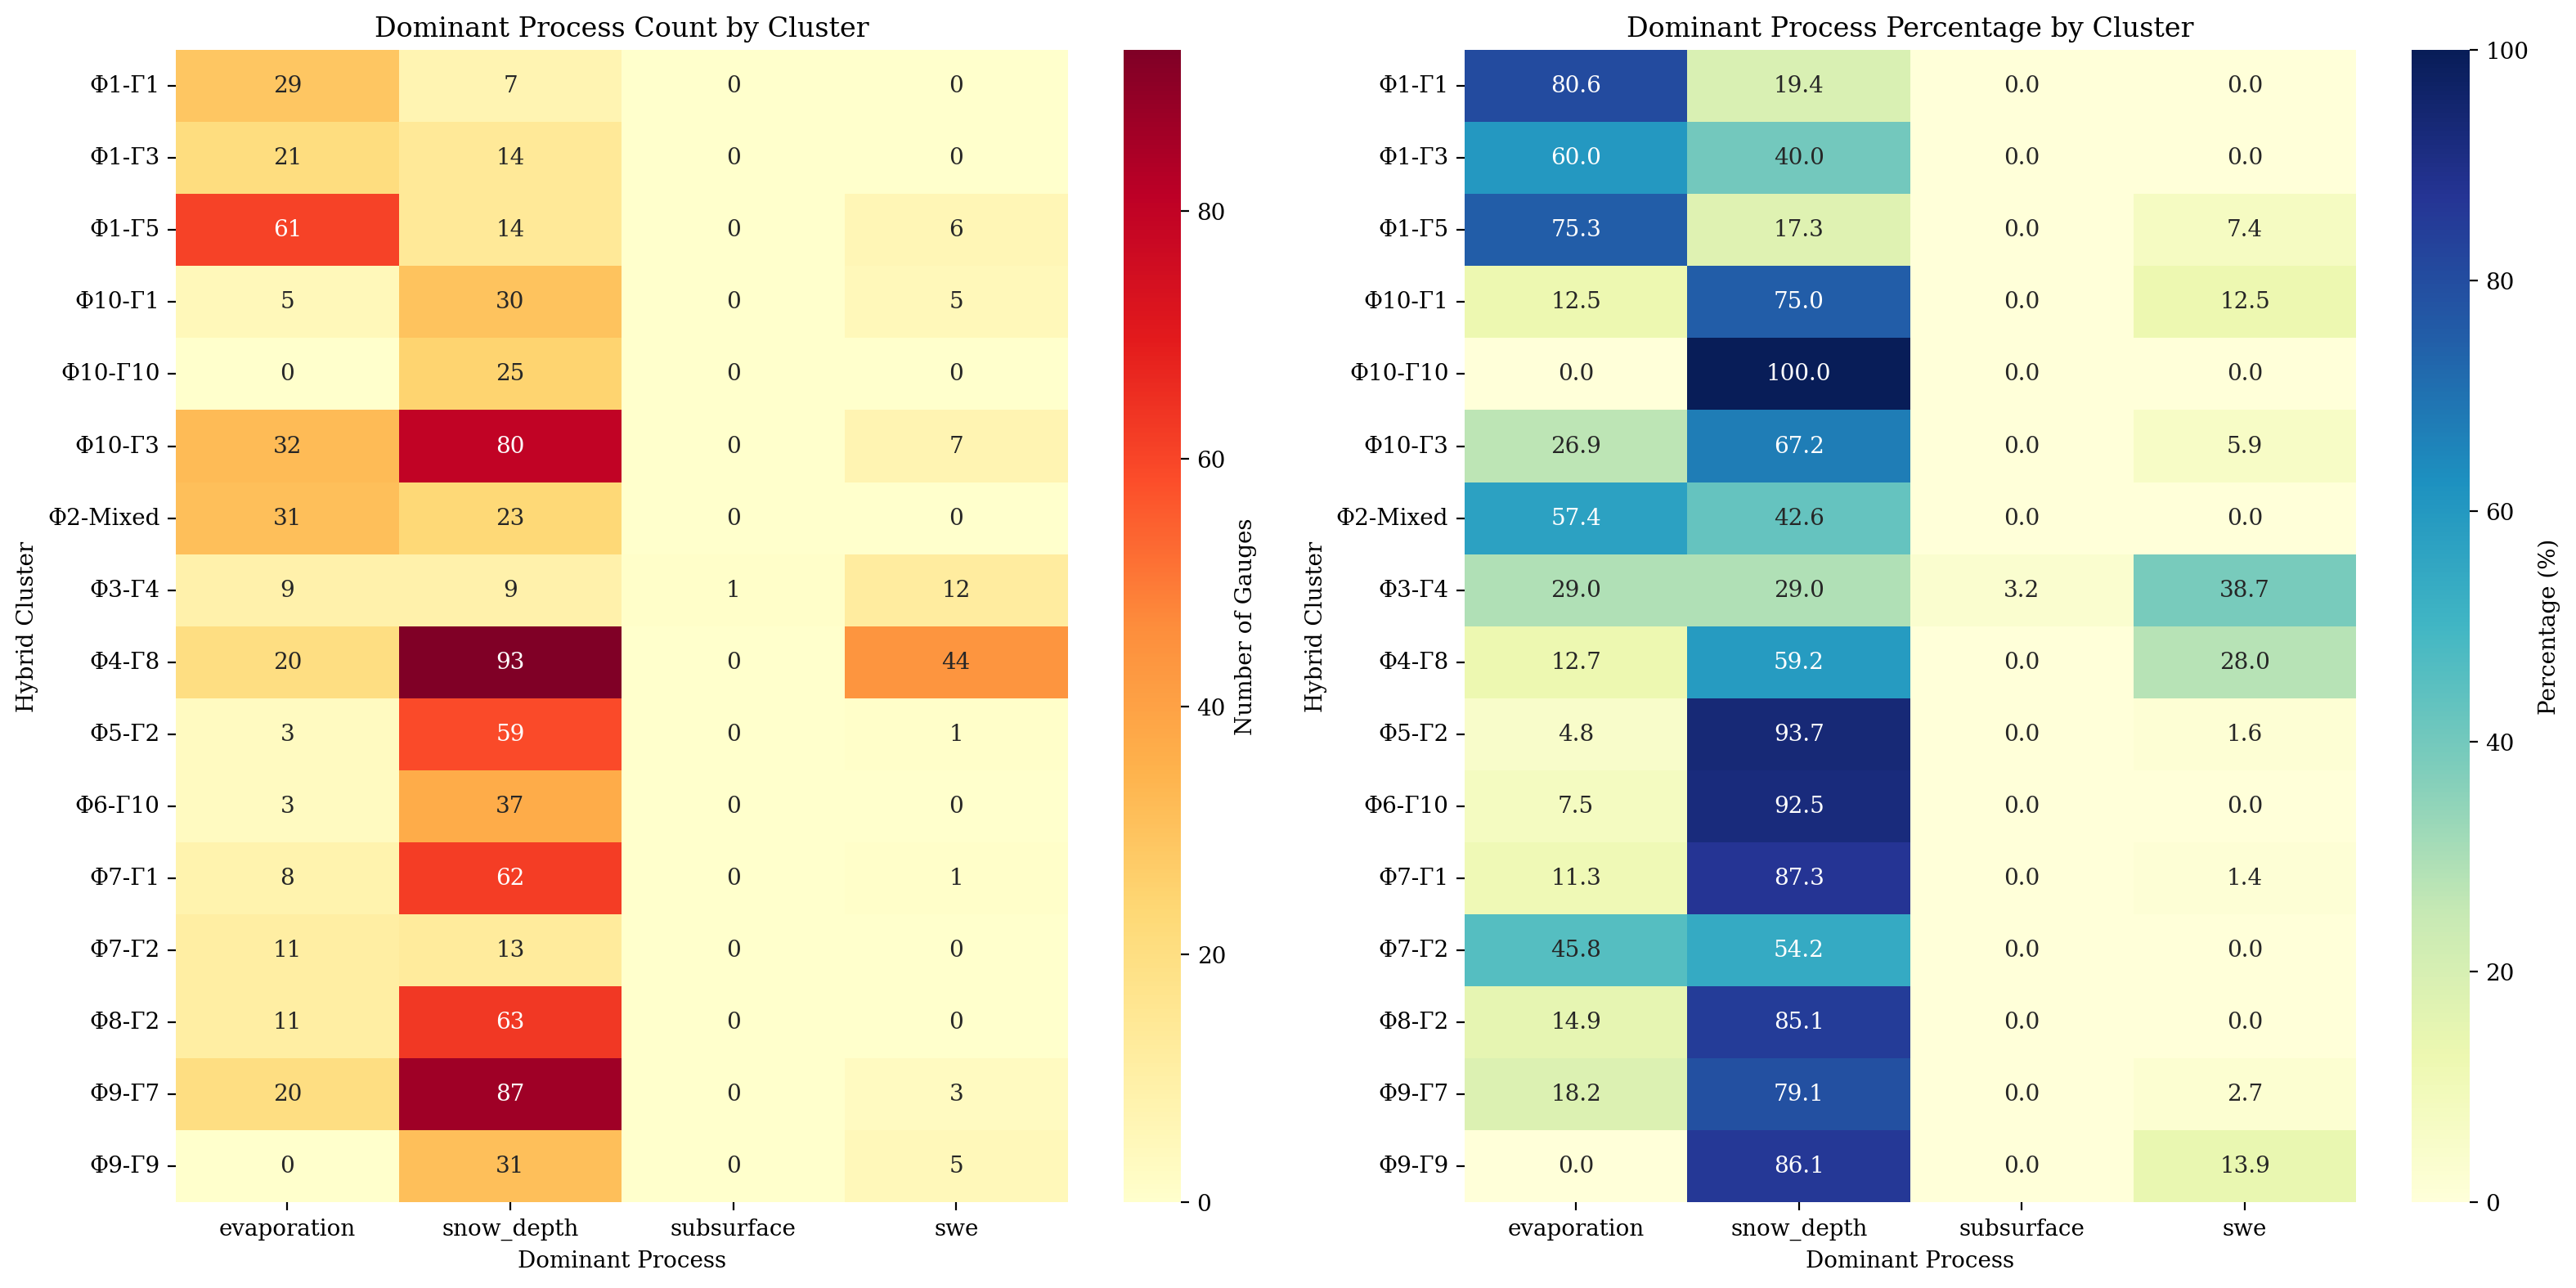

In [29]:
# =============================================================================
# Visualization: Cluster-Process Heatmap (dominant process by cluster)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Left: Count heatmap
ax1 = axes[0]
plot_data = cluster_process_counts.drop("All", axis=0).drop("All", axis=1)
sns.heatmap(
    plot_data,
    ax=ax1,
    annot=True,
    fmt="d",
    cmap="YlOrRd",
    cbar_kws={"label": "Number of Gauges"},
)
ax1.set_title("Dominant Process Count by Cluster", fontsize=12)
ax1.set_xlabel("Dominant Process")
ax1.set_ylabel("Hybrid Cluster")

# Right: Percentage heatmap
ax2 = axes[1]
plot_pct = (
    cluster_process_pct.drop("All", axis=0)
    if "All" in cluster_process_pct.index
    else cluster_process_pct
)
sns.heatmap(
    plot_pct,
    ax=ax2,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    cbar_kws={"label": "Percentage (%)"},
)
ax2.set_title("Dominant Process Percentage by Cluster", fontsize=12)
ax2.set_xlabel("Dominant Process")
ax2.set_ylabel("Hybrid Cluster")

plt.tight_layout()
plt.savefig(image_dir / "lstm_cluster_process_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

In [30]:
# =============================================================================
# Spatial Map: Cluster-aggregated Dominant Process
# =============================================================================
# For each cluster, determine the most common dominant process

cluster_dominant = (
    gauge_cluster_process.groupby("hybrid_class")["dominant_process"]
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)
cluster_dominant.columns = ["hybrid_class", "cluster_dominant_process"]

# Merge with watershed geometries
ws_cluster_process = ws.copy()
ws_cluster_process["hybrid_class"] = hybrid_clusters.reindex(ws_cluster_process.index)
ws_cluster_process = ws_cluster_process.merge(
    cluster_dominant, on="hybrid_class", how="left"
)

# Map process to numeric for coloring
process_to_num = {"evaporation": 1, "swe": 2, "snow_depth": 3, "subsurface": 4}
ws_cluster_process["process_num"] = ws_cluster_process["cluster_dominant_process"].map(
    process_to_num
)

print("Cluster dominant processes:")
print(cluster_dominant)

Cluster dominant processes:
   hybrid_class cluster_dominant_process
0         Ф1-Г1              evaporation
1         Ф1-Г3              evaporation
2         Ф1-Г5              evaporation
3        Ф10-Г1               snow_depth
4       Ф10-Г10               snow_depth
5        Ф10-Г3               snow_depth
6      Ф2-Mixed              evaporation
7         Ф3-Г4                      swe
8         Ф4-Г8               snow_depth
9         Ф5-Г2               snow_depth
10       Ф6-Г10               snow_depth
11        Ф7-Г1               snow_depth
12        Ф7-Г2               snow_depth
13        Ф8-Г2               snow_depth
14        Ф9-Г7               snow_depth
15        Ф9-Г9               snow_depth


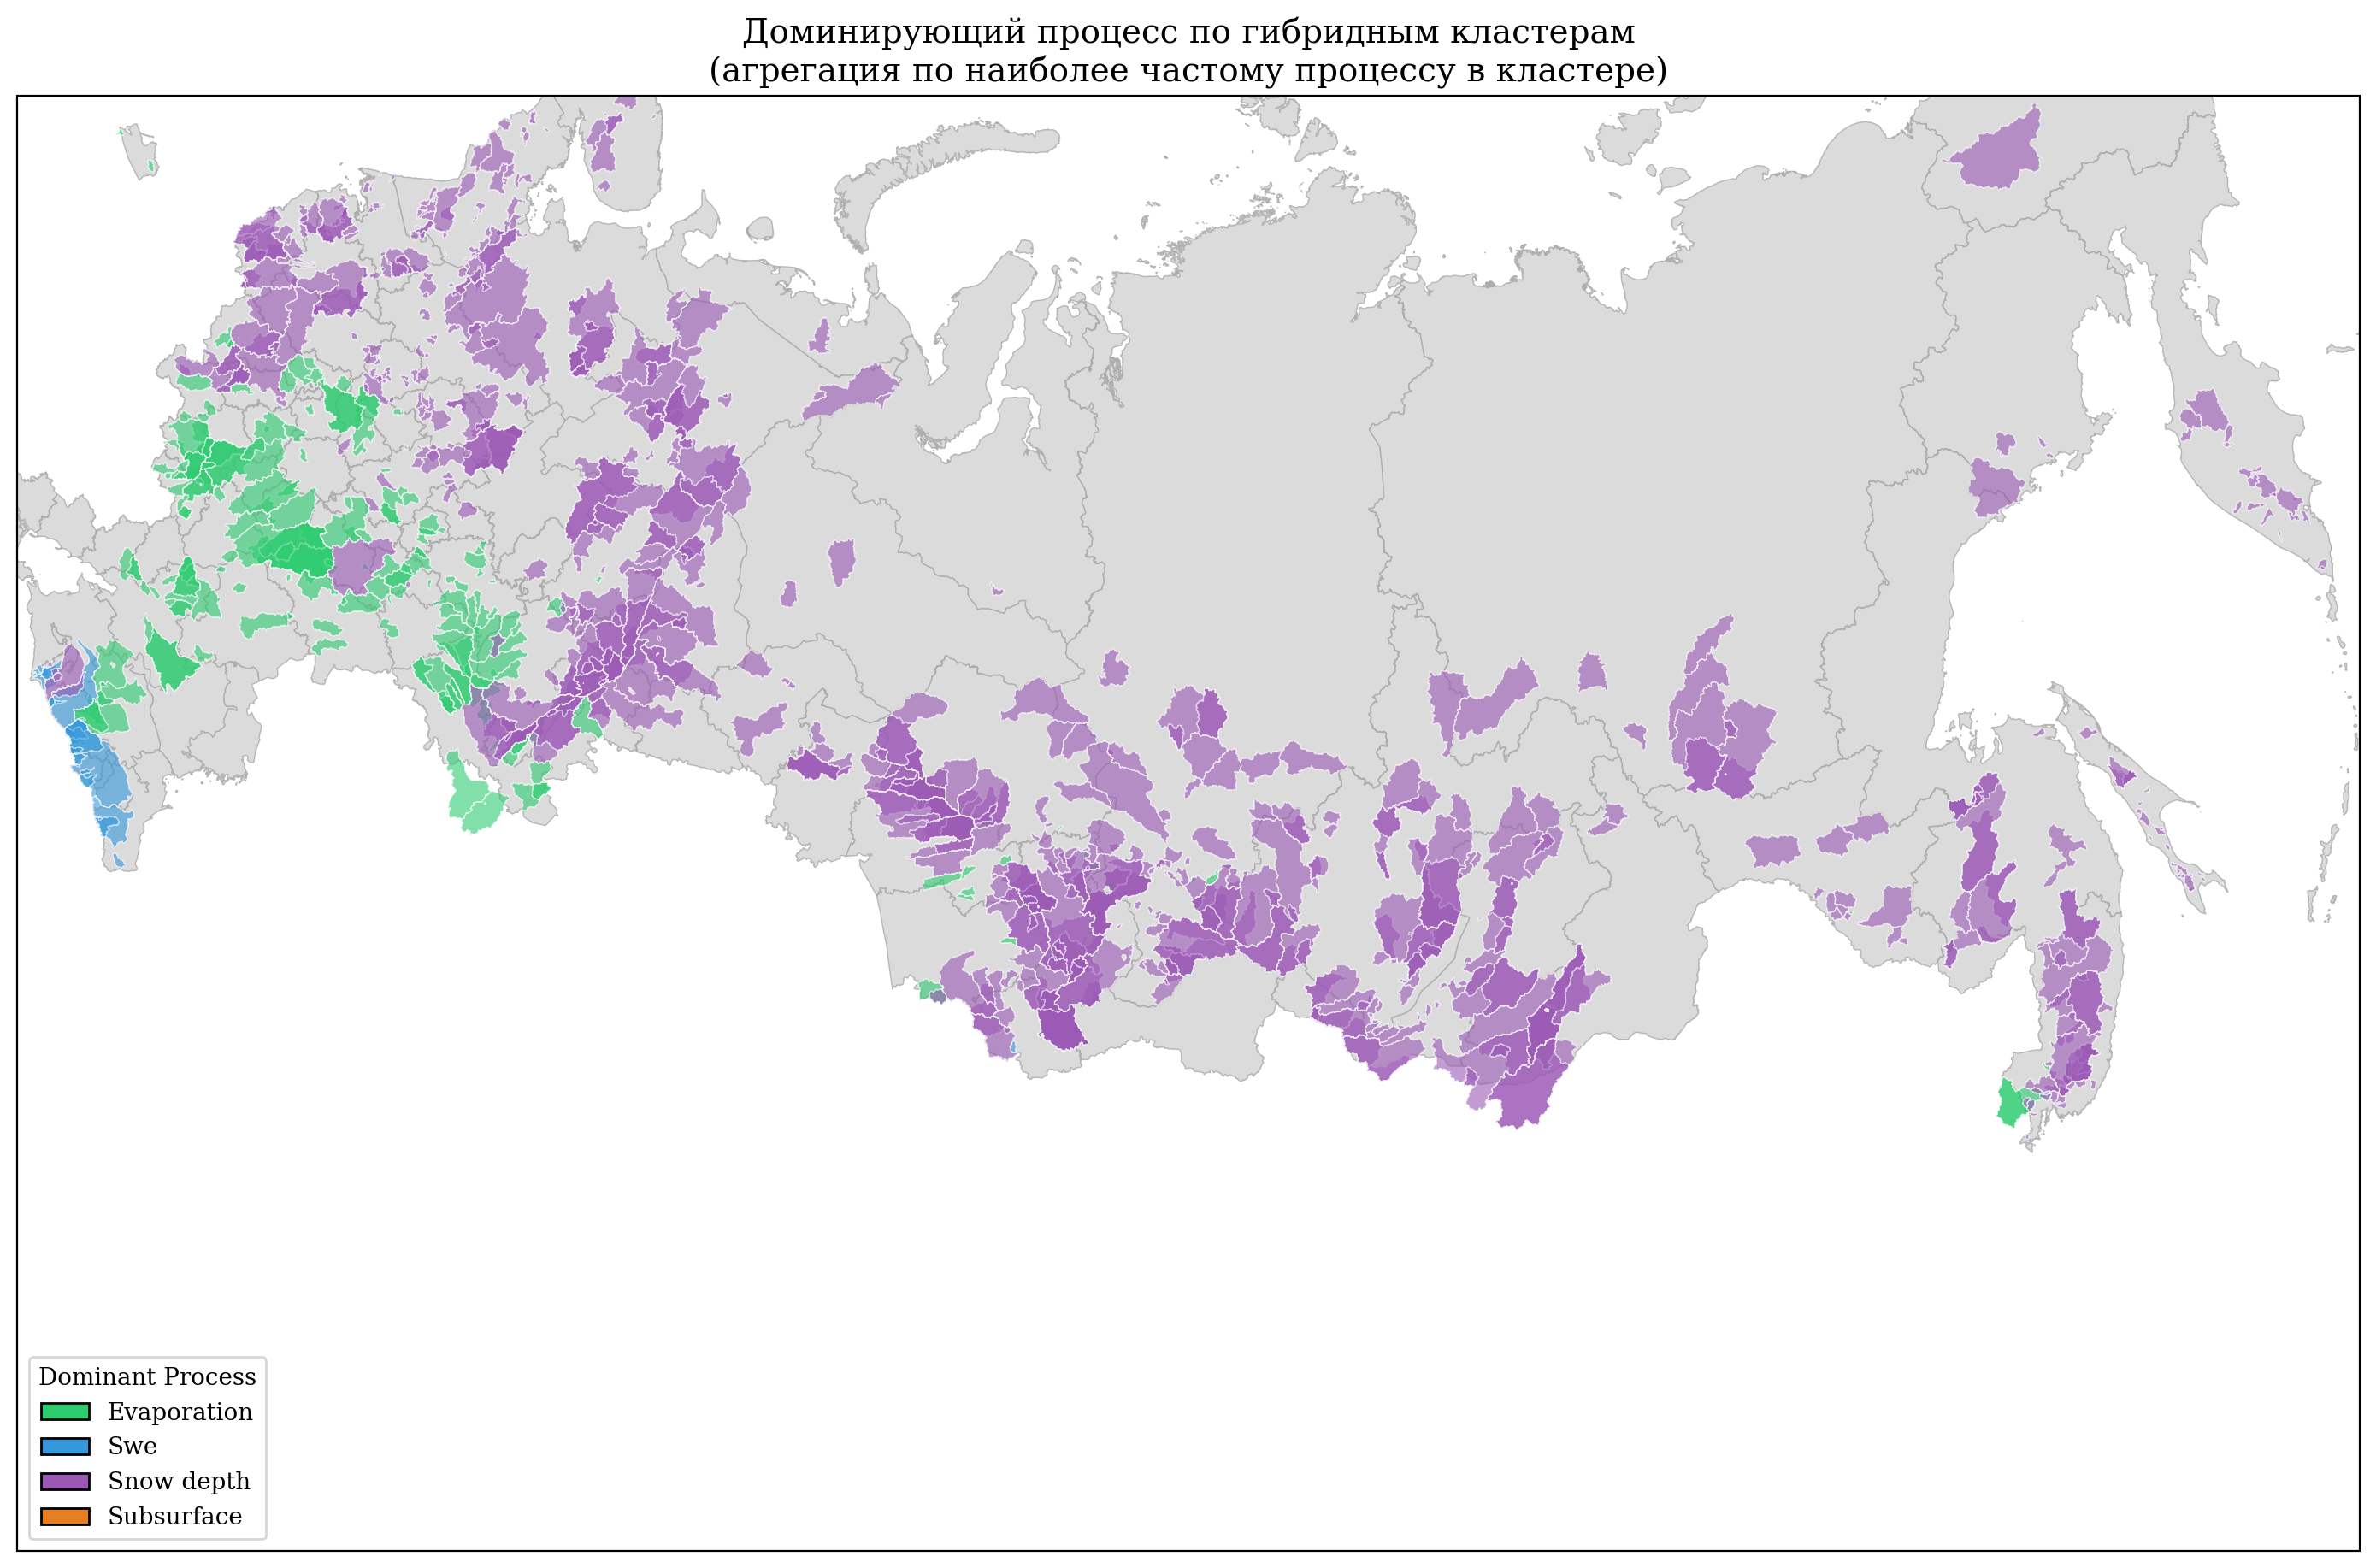

In [31]:
# =============================================================================
# Hex Map: Cluster Dominant Process Spatial Distribution
# =============================================================================
from matplotlib.patches import Patch

fig, ax = plt.subplots(
    figsize=(14, 10),
    subplot_kw={
        "projection": ccrs.AlbersEqualArea(
            central_longitude=100,
            standard_parallels=(50, 70),
            central_latitude=56,
        )
    },
)

# Plot basemap
basemap_data.to_crs(ax.projection.proj4_init).plot(
    ax=ax, color="lightgray", edgecolor="darkgray", linewidth=0.5, alpha=0.8
)

# Plot each cluster's watersheds with dominant process color
ws_plot = ws_cluster_process.dropna(subset=["cluster_dominant_process"])

for process in ["evaporation", "swe", "snow_depth", "subsurface"]:
    subset = ws_plot[ws_plot["cluster_dominant_process"] == process]
    if len(subset) > 0:
        subset.to_crs(ax.projection.proj4_init).plot(
            ax=ax,
            color=process_colors[process],
            alpha=0.6,
            edgecolor="white",
            linewidth=0.3,
        )

# Legend
legend_patches = [
    Patch(
        facecolor=process_colors[p],
        edgecolor="black",
        label=p.replace("_", " ").capitalize(),
    )
    for p in ["evaporation", "swe", "snow_depth", "subsurface"]
]
ax.legend(handles=legend_patches, loc="lower left", fontsize=10, title="Dominant Process")

ax.set_title(
    "Доминирующий процесс по гибридным кластерам\n(агрегация по наиболее частому процессу в кластере)",
    fontsize=14,
)
ax.set_extent([50, 140, 35, 75], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.savefig(
    image_dir / "lstm_cluster_dominant_process_map.png", dpi=150, bbox_inches="tight"
)
plt.show()

In [32]:
# =============================================================================
# Summary Table: Cluster Characteristics
# =============================================================================
# Create a comprehensive table for each cluster

cluster_summary = []

for cluster in sorted(hybrid_clusters.unique()):
    cluster_gauges = hybrid_clusters[hybrid_clusters == cluster].index
    cluster_gauges_in_analysis = [
        g for g in cluster_gauges if g in gauge_cluster_process.index
    ]

    if len(cluster_gauges_in_analysis) == 0:
        continue

    # Dominant process in cluster
    subset = gauge_cluster_process[gauge_cluster_process["hybrid_class"] == cluster]
    dom_process = (
        subset["dominant_process"].value_counts().idxmax() if len(subset) > 0 else "N/A"
    )
    dom_pct = (
        subset["dominant_process"].value_counts(normalize=True).max() * 100
        if len(subset) > 0
        else 0
    )

    # Best cells for this cluster's dominant process
    if dom_process in correlation_matrices:
        cluster_corr = correlation_matrices[dom_process].loc[
            correlation_matrices[dom_process].index.isin(cluster_gauges_in_analysis)
        ]
        if len(cluster_corr) > 0:
            top_cell = cluster_corr.abs().mean().idxmax()
            top_r = cluster_corr.abs().mean().max()
        else:
            top_cell, top_r = "N/A", 0
    else:
        top_cell, top_r = "N/A", 0

    cluster_summary.append(
        {
            "Cluster": cluster,
            "N Gauges": len(cluster_gauges_in_analysis),
            "Dominant Process": dom_process,
            "Dom. %": f"{dom_pct:.1f}%",
            "Top Cell": top_cell,
            "Top |r|": f"{top_r:.3f}" if isinstance(top_r, float) else top_r,
        }
    )

cluster_summary_df = pd.DataFrame(cluster_summary)
print("=" * 70)
print("CLUSTER SUMMARY TABLE")
print("=" * 70)
print(cluster_summary_df.to_string(index=False))

# Save to CSV
cluster_summary_df.to_csv(table_dir / "lstm_cluster_summary.csv", index=False)
print(f"\nSaved: {table_dir / 'lstm_cluster_summary.csv'}")

CLUSTER SUMMARY TABLE
 Cluster  N Gauges Dominant Process Dom. %  Top Cell Top |r|
   Ф1-Г1        36      evaporation  80.6%         0   0.868
   Ф1-Г3        35      evaporation  60.0%         0   0.866
   Ф1-Г5        81      evaporation  75.3%         0   0.853
  Ф10-Г1        40       snow_depth  75.0%        41   0.833
 Ф10-Г10        25       snow_depth 100.0%       143   0.920
  Ф10-Г3       119       snow_depth  67.2%       143   0.807
Ф2-Mixed        54      evaporation  57.4%         0   0.854
   Ф3-Г4        31              swe  38.7%       149   0.738
   Ф4-Г8       157       snow_depth  59.2%       186   0.855
   Ф5-Г2        63       snow_depth  93.7%        41   0.853
  Ф6-Г10        40       snow_depth  92.5%       143   0.880
   Ф7-Г1        71       snow_depth  87.3%       143   0.852
   Ф7-Г2        24       snow_depth  54.2%        56   0.814
   Ф8-Г2        74       snow_depth  85.1%       143   0.837
   Ф9-Г7       110       snow_depth  79.1%       143   0.824
  

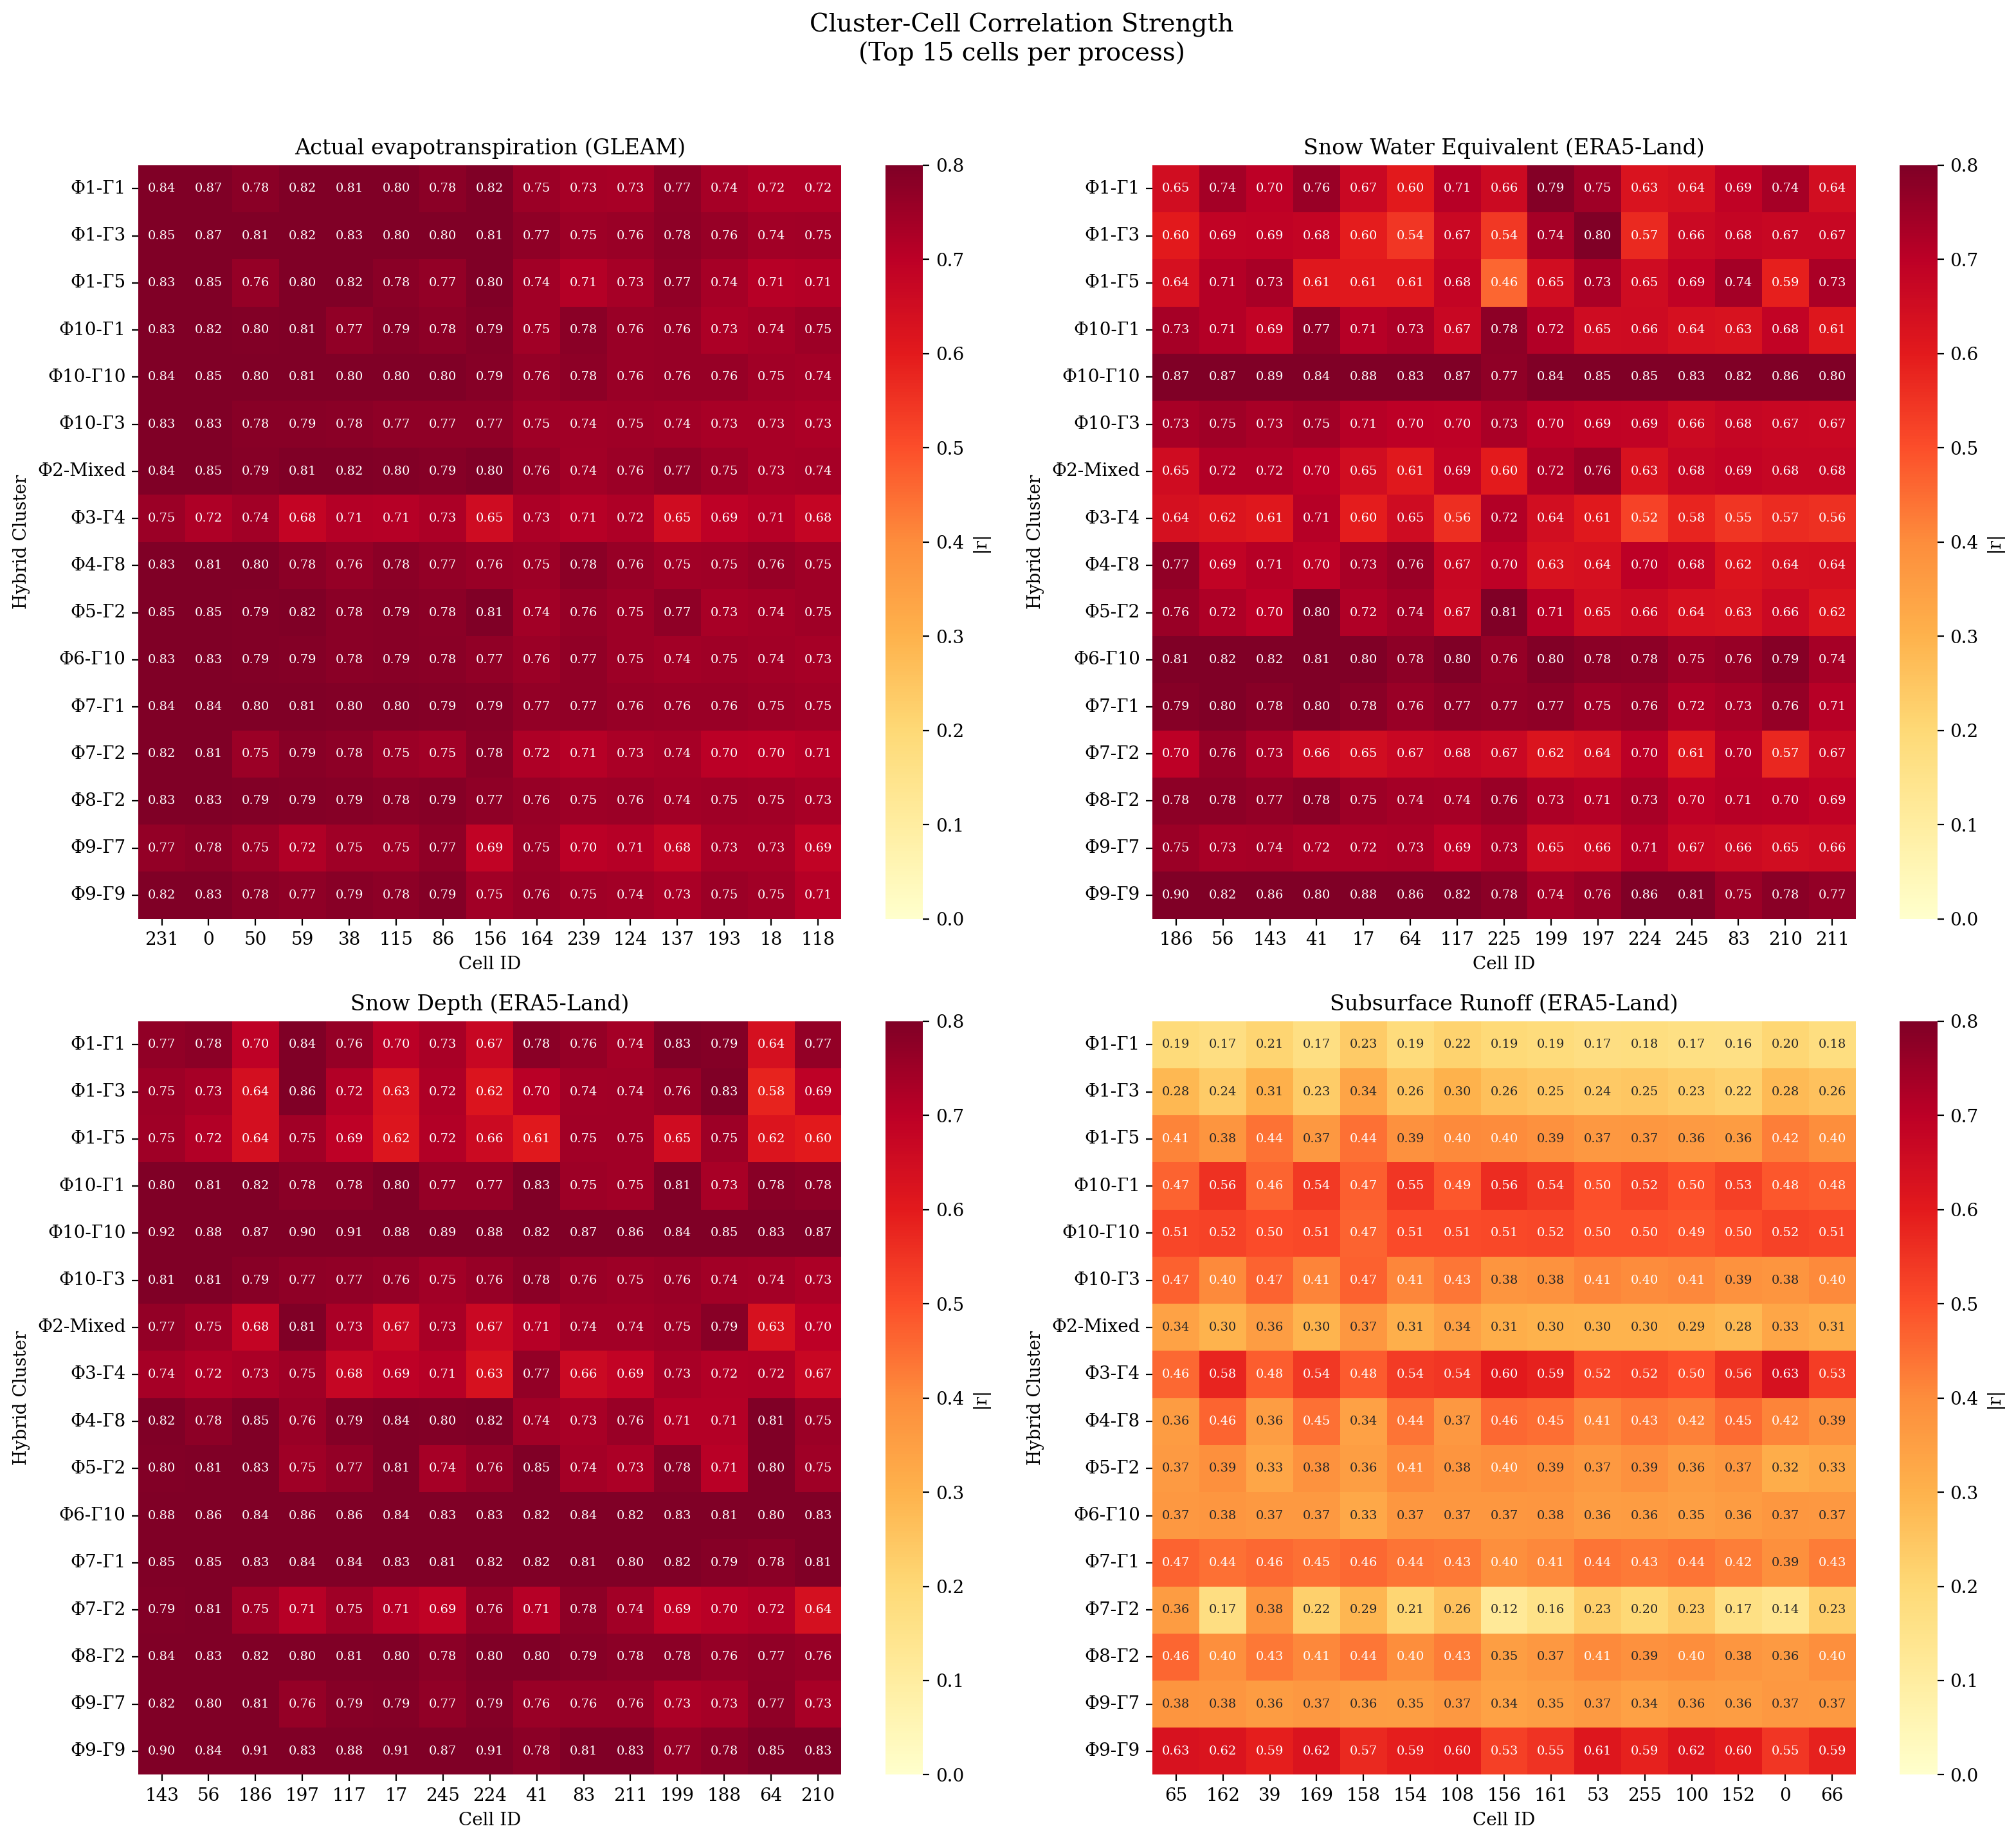

In [33]:
# =============================================================================
# Visualization: Cluster-Cell Importance Heatmap
# =============================================================================
# For each cluster and process, show the top 3 cells

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (param_name, param_info) in enumerate(METEO_PARAMS.items()):
    ax = axes[idx]

    # Build cluster x cell matrix (mean correlation)
    clusters = sorted(hybrid_clusters.unique())
    n_top_cells = 15  # Show top 15 cells for this parameter

    # Get globally top cells for this parameter
    global_top = cell_process_matrix[param_name].nlargest(n_top_cells).index.tolist()

    cluster_cell_matrix = pd.DataFrame(index=clusters, columns=global_top, dtype=float)

    for cluster in clusters:
        cluster_gauges = hybrid_clusters[hybrid_clusters == cluster].index
        cluster_gauges = [
            g for g in cluster_gauges if g in correlation_matrices[param_name].index
        ]

        if len(cluster_gauges) > 0:
            cluster_corr = correlation_matrices[param_name].loc[cluster_gauges]
            for cell in global_top:
                if cell in cluster_corr.columns:
                    cluster_cell_matrix.loc[cluster, cell] = (
                        cluster_corr[cell].abs().mean()
                    )

    # Plot heatmap
    sns.heatmap(
        cluster_cell_matrix.astype(float),
        ax=ax,
        cmap="YlOrRd",
        vmin=0,
        vmax=0.8,
        annot=True,
        fmt=".2f",
        annot_kws={"fontsize": 7},
        cbar_kws={"label": "|r|"},
    )
    ax.set_title(f"{param_info['description']}", fontsize=12)
    ax.set_xlabel("Cell ID")
    ax.set_ylabel("Hybrid Cluster")

plt.suptitle(
    "Cluster-Cell Correlation Strength\n(Top 15 cells per process)",
    fontsize=14,
    y=1.02,
)
plt.tight_layout()
plt.savefig(image_dir / "lstm_cluster_cell_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

## Cluster-Cell Analysis Summary

### Key Findings:

1. **Cluster-Process Distribution**: The heatmap shows how different hybrid clusters are dominated by different physical processes
2. **Spatial Patterns**: The map reveals geographic patterns in which processes the LSTM learns to represent
3. **Cell Specialization**: Some cells are universally important across clusters, while others are cluster-specific

### Output Files:
- `lstm_cluster_process_heatmap.png` - Count/percentage of dominant processes by cluster
- `lstm_cluster_dominant_process_map.png` - Spatial visualization of cluster-level dominant processes
- `lstm_cluster_cell_heatmap.png` - Cluster x Cell importance matrix
- `lstm_cluster_summary.csv` - Summary table with cluster characteristics

# Cell State (c_n) Analysis

The LSTM has two types of internal state:
- **h_n (hidden state)**: Output of the LSTM cell, used for predictions
- **c_n (cell state)**: Long-term memory, carries information across many timesteps

Below we analyze c_n to see if it captures different physical processes than h_n.

In [34]:
# =============================================================================
# Extract and analyze c_n (cell state)
# =============================================================================
C_STATE_TYPE = "c_n"

if C_STATE_TYPE in states.keys():
    raw_c_states = states[C_STATE_TYPE]
    print(f"Using state type: {C_STATE_TYPE}")
    print(f"Raw shape: {raw_c_states.shape}")

    # Extract last timestep: (n_samples, hidden_size)
    if len(raw_c_states.shape) == 3:
        c_states_all = raw_c_states[:, -1, :]
    else:
        c_states_all = raw_c_states

    print(f"Cell states (c_n) shape: {c_states_all.shape}")
else:
    raise ValueError(f"State type '{C_STATE_TYPE}' not found in saved states")

Using state type: c_n
Raw shape: (731, 365, 256)
Cell states (c_n) shape: (731, 256)


In [35]:
# =============================================================================
# Compute correlations for c_n states
# =============================================================================
c_correlation_matrices = {}

for param_name, param_info in METEO_PARAMS.items():
    print(f"\nProcessing c_n correlations for: {param_name}")
    param_file = param_info["file"]

    # Load parameter data
    param_df = pd.read_parquet(param_file)
    if "date" in param_df.columns:
        param_df = param_df.set_index("date")

    # Initialize correlation matrix
    c_corr_matrix = pd.DataFrame(
        index=common_index, columns=range(hidden_size), dtype=float
    )

    for gauge_id in common_index:
        gauge_idx = gauge_id_to_idx.get(gauge_id, None)
        if gauge_idx is None or gauge_id not in param_df.columns:
            continue

        # Get gauge's c_n states and parameter values
        gauge_c_states = c_states_all[time_index_to_sample == gauge_idx]
        param_values = param_df.loc[common_dates, gauge_id].values

        if len(gauge_c_states) != len(param_values):
            continue

        # Compute correlation for each cell
        for cell_idx in range(hidden_size):
            cell_values = gauge_c_states[:, cell_idx]
            valid_mask = ~np.isnan(param_values) & ~np.isnan(cell_values)
            if valid_mask.sum() > 30:
                r, _ = pearsonr(cell_values[valid_mask], param_values[valid_mask])
                c_corr_matrix.loc[gauge_id, cell_idx] = r

    c_correlation_matrices[param_name] = c_corr_matrix.dropna(how="all")
    print(f"  Valid gauges: {len(c_correlation_matrices[param_name])}")

print("\nc_n correlation matrices computed!")


Processing c_n correlations for: evaporation


KeyError: 'file'

In [ ]:
# =============================================================================
# Define Cell Groups for c_n (same logic as h_n)
# =============================================================================
c_cell_process_matrix = pd.DataFrame(index=range(hidden_size))

for param_name, corr_df in c_correlation_matrices.items():
    mean_abs_corr = corr_df.abs().mean()
    c_cell_process_matrix[param_name] = mean_abs_corr.values

# Determine primary process for each cell
c_cell_process_matrix["max_corr"] = c_cell_process_matrix[list(METEO_PARAMS.keys())].max(
    axis=1
)
c_cell_process_matrix["primary_process"] = c_cell_process_matrix[
    list(METEO_PARAMS.keys())
].idxmax(axis=1)

# Mark inactive cells
c_cell_process_matrix.loc[
    c_cell_process_matrix["max_corr"] < MIN_CORRELATION, "primary_process"
] = "inactive"

# Create cell groups for c_n
c_cell_groups = {param: [] for param in list(METEO_PARAMS.keys())}
c_cell_groups["inactive"] = []

for cell_id in range(hidden_size):
    primary = c_cell_process_matrix.loc[cell_id, "primary_process"]
    if primary in c_cell_groups:
        c_cell_groups[primary].append(cell_id)

# Display results
print("=" * 70)
print("c_n CELL GROUPS BY PROCESS")
print("=" * 70)

for process in list(METEO_PARAMS.keys()) + ["inactive"]:
    n_cells = len(c_cell_groups[process])
    if n_cells > 0 and process != "inactive":
        avg_corr = c_cell_process_matrix.loc[c_cell_groups[process], process].mean()
        print(f"\n{process.upper()} ({n_cells} cells): Avg |r| = {avg_corr:.3f}")
    elif process == "inactive":
        print(f"\nINACTIVE ({n_cells} cells)")

In [ ]:
# =============================================================================
# Compare h_n vs c_n cell assignments
# =============================================================================
print("=" * 70)
print("COMPARISON: h_n vs c_n Cell Assignments")
print("=" * 70)

comparison_data = []
for process in list(METEO_PARAMS.keys()) + ["inactive"]:
    h_cells = set(cell_groups[process])
    c_cells = set(c_cell_groups[process])

    overlap = h_cells & c_cells
    h_only = h_cells - c_cells
    c_only = c_cells - h_cells

    comparison_data.append(
        {
            "Process": process,
            "h_n cells": len(h_cells),
            "c_n cells": len(c_cells),
            "Overlap": len(overlap),
            "h_n only": len(h_only),
            "c_n only": len(c_only),
        }
    )

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Calculate overall agreement
total_same = sum(
    1
    for i in range(hidden_size)
    if cell_process_matrix.loc[i, "primary_process"]
    == c_cell_process_matrix.loc[i, "primary_process"]
)
print(
    f"\nOverall agreement: {total_same}/{hidden_size} cells ({100 * total_same / hidden_size:.1f}%)"
)

COMPARISON: h_n vs c_n Cell Assignments


NameError: name 'c_cell_groups' is not defined

NameError: name 'c_cell_process_matrix' is not defined

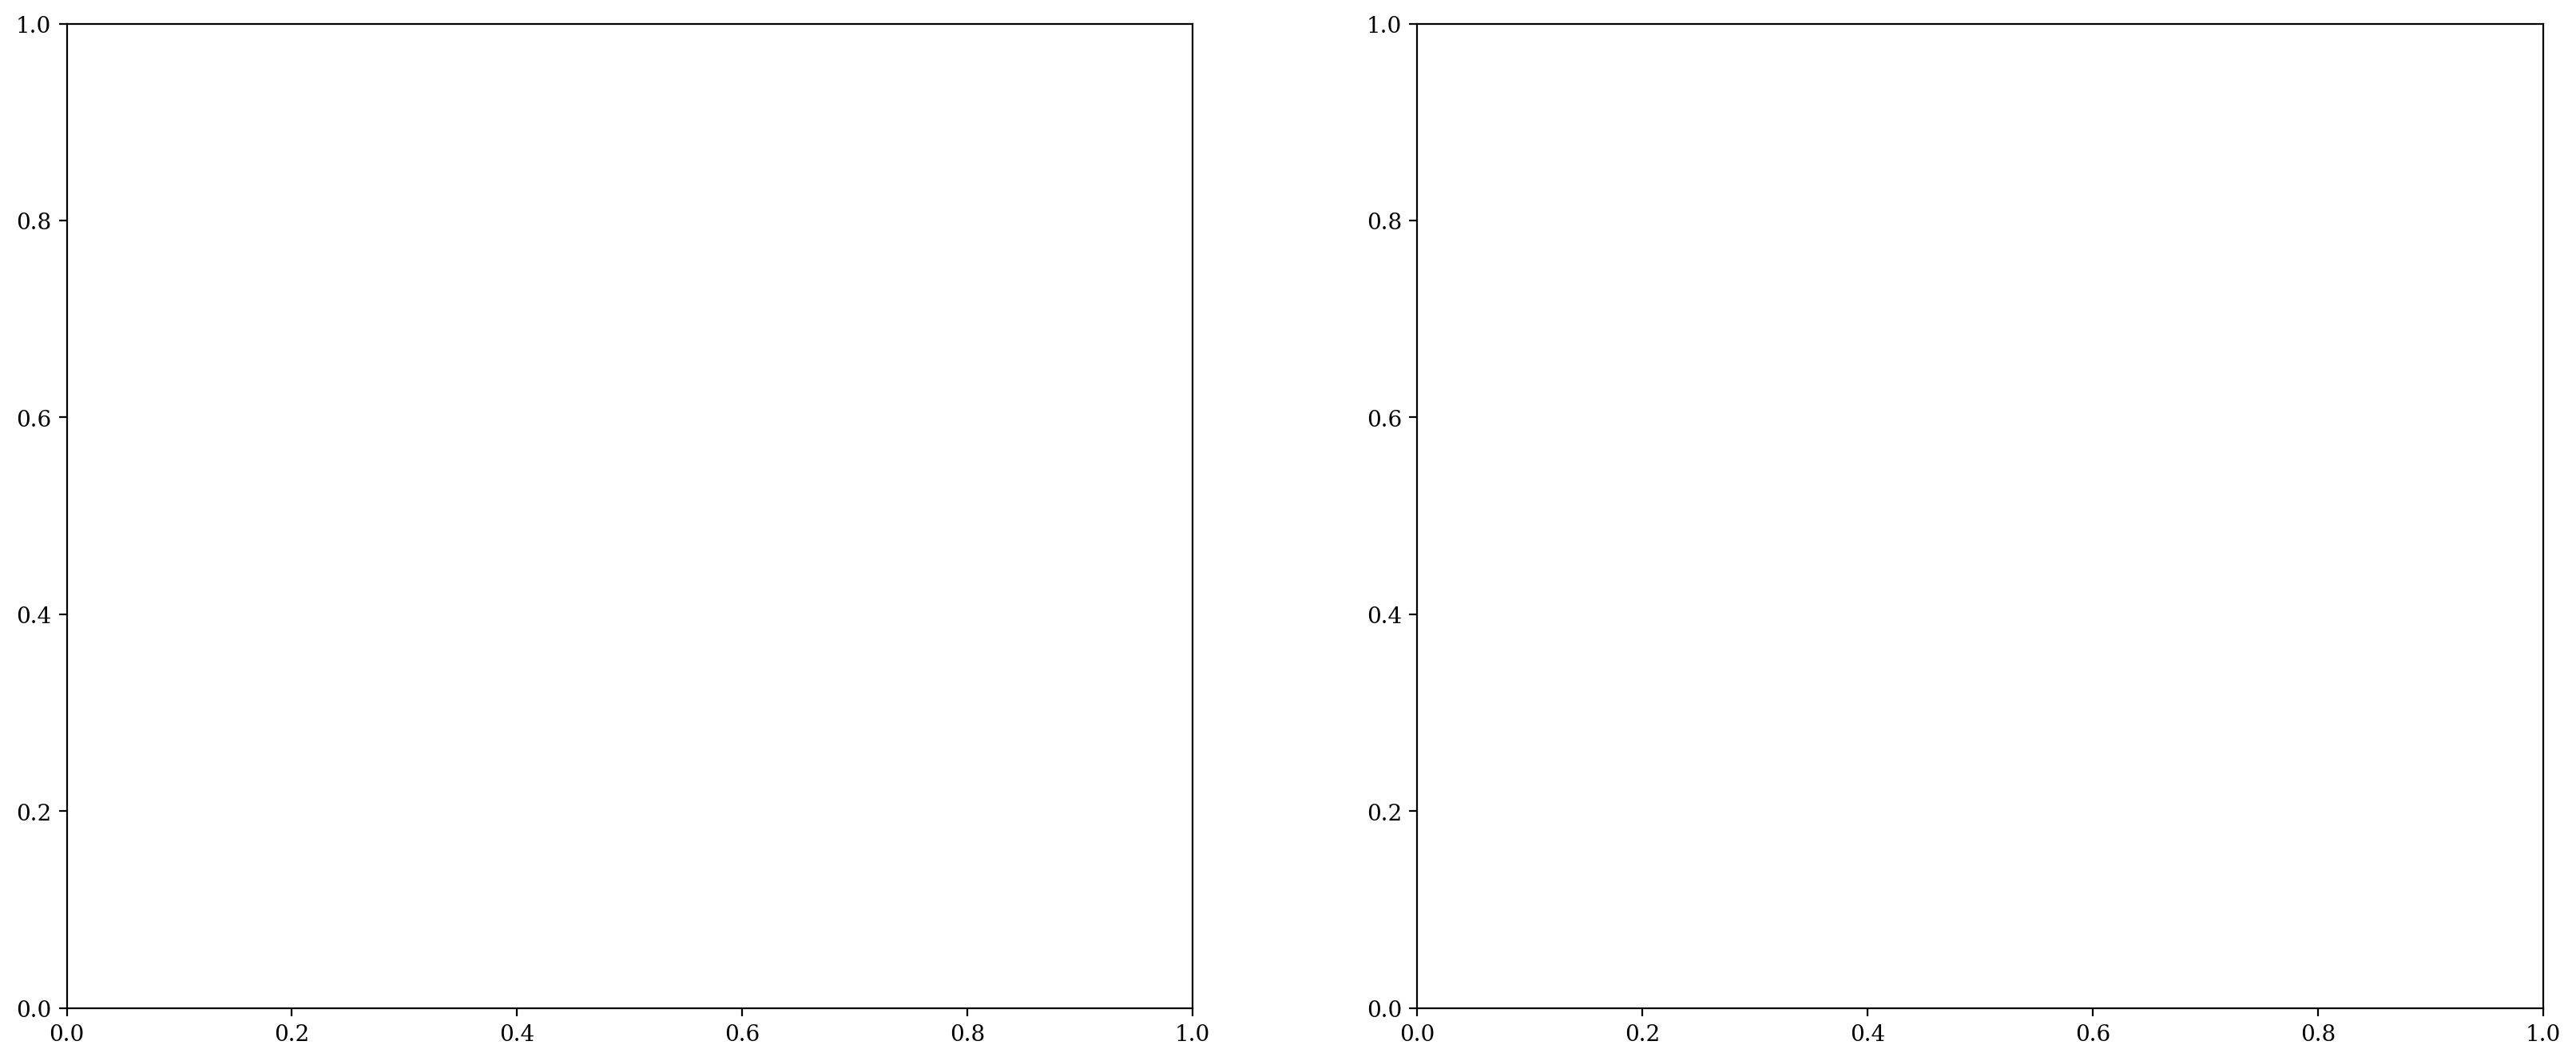

In [ ]:
# =============================================================================
# Visualization: h_n vs c_n Side-by-Side Grid
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

grid_size = int(np.sqrt(hidden_size))

for ax_idx, (state_type, proc_matrix, title) in enumerate(
    [
        ("h_n", cell_process_matrix, "Hidden State (h_n)"),
        ("c_n", c_cell_process_matrix, "Cell State (c_n)"),
    ]
):
    ax = axes[ax_idx]
    cell_grid = np.zeros((grid_size, grid_size, 3))

    for i in range(hidden_size):
        row = i // grid_size
        col = i % grid_size
        process = proc_matrix.loc[i, "primary_process"]
        color_hex = process_colors.get(process, "#bdc3c7")
        rgb = tuple(int(color_hex.lstrip("#")[j : j + 2], 16) / 255 for j in (0, 2, 4))
        cell_grid[row, col] = rgb

    ax.imshow(cell_grid, aspect="equal")

    # Add grid lines
    for i in range(grid_size + 1):
        ax.axhline(i - 0.5, color="white", linewidth=0.5)
        ax.axvline(i - 0.5, color="white", linewidth=0.5)

    ax.set_xlabel("Column", fontsize=12)
    ax.set_ylabel("Row", fontsize=12)
    ax.set_title(f"{title}\nProcess Assignments", fontsize=14)

# Shared legend
legend_elements = [
    plt.Rectangle(
        (0, 0), 1, 1, facecolor=process_colors[p], label=p.replace("_", " ").capitalize()
    )
    for p in ["evaporation", "swe", "snow_depth", "subsurface", "inactive"]
]
fig.legend(
    handles=legend_elements, loc="center right", bbox_to_anchor=(1.12, 0.5), fontsize=10
)

plt.tight_layout()
plt.savefig(image_dir / "lstm_hn_cn_comparison_grid.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# =============================================================================
# Save c_n cell groups
# =============================================================================
# Save c_n cell assignments
c_groups_export = pd.DataFrame(
    [
        {
            "cell_id": cell_id,
            "primary_process": c_cell_process_matrix.loc[cell_id, "primary_process"],
        }
        for cell_id in range(hidden_size)
    ]
)
c_groups_export.to_csv(table_dir / "lstm_cn_cell_groups.csv", index=False)

# Save comparison summary
comparison_df.to_csv(table_dir / "lstm_hn_cn_comparison.csv", index=False)

print(f"Saved: {table_dir / 'lstm_cn_cell_groups.csv'}")
print(f"Saved: {table_dir / 'lstm_hn_cn_comparison.csv'}")

## h_n vs c_n Summary

| State Type | Description | Characteristics |
|------------|-------------|-----------------|
| **h_n** | Hidden state | Output of LSTM, captures recent patterns |
| **c_n** | Cell state | Long-term memory, captures persistent patterns |

The comparison reveals whether h_n and c_n specialize in different processes or show similar patterns.